Jupyter Notebook for AFNI preprocessing and pRF mapping of the primary visual cortex using public Human Connectome Project Data (Benson et al., 2018) with afni, freesurfer and neuropythy (citations).

The Human Connectome Data is manually converted into BIDS-like organisation/format with pseudo-BIDS naming. No json sidecars have been created for the files, or the dataset description.
    The dataset is organised like so: 
~/hcp_retinotopy/code/...
----------------/derivatives/
--------------------/afni-preproc/...
--------------------/freesurfer/...
----------------/sourcedata/
--------------------/sub-01/
------------------------/anat/...
------------------------/func/...
------------------------/fmap/...
----------------/stimuli/...

The script uses containerised version of afni, freesurfer, and neuropythy via singularity and podman which are controlled by helper functions, see below. Singularity containers are the prefered method for running this on the lovelace HPC.

In [1]:
## Libraries to import
# These libraries are installed within the ~/bric/.venv environment and available using the jupyter venv_test_kernel
import subprocess
import os
from pathlib import Path
import re
from typing import List, Dict
import glob
from multiprocessing import Pool, cpu_count
print("Libraries imported successfully :)")

Libraries imported successfully :)


In [2]:
## Global configuration
# 'docker' (use for both docker and podman containers) / 'singularity'
CONTAINER_TYPE = "singularity"
# Name of container / path to container (.sif)
CONTAINER_NAME = "~/bric/containers/afni_25.2.17_stable/afni_25.2.17_stable.sif" 

# Directory specifications
base_dir = Path.home() / "datasets" / "hcp_retinotopy" # Creates a Path object for the base directory of the dataset
subjects = ["sub-01"] # List of subject IDs to process -  This is currently static but should be updated to include all subjects found in the base_dir
overwrite = False  # Whether to overwrite existing outputs - This currently does not modify afni commands with a relevant overwrite flag

# General preprocessing parameters
epi_drop = 0            # Number of initial volumes to drop

# pRF mapping parameters
model_type = "2D Gaussian"  # Type of pRF model
grid_size = 50  # Size of the grid for model fitting
num_iterations = 1000  # Number of iterations for model fitting

print(f"Base directory: {base_dir}")
print(f"Subjects found: {subjects}")

Base directory: /users/kltoomer/datasets/hcp_retinotopy
Subjects found: ['sub-01']


In [ ]:
## Helper functions
# Run general shell commands
def run_cmd(cmd: str, shell: bool = True, check: bool = True) -> subprocess.CompletedProcess:
    """Execute shell command and return output/error"""
    result = subprocess.run(cmd, shell=shell, capture_output=True, text=True, check=check)
    if result.stdout: print(f"Output: {result.stdout}")
    elif result.stderr: print(f"Error: {result.stderr}")
    return result

# Run commands in specified containers containers 
# - Need to add overwrite args, appending 'force' to afni command input (will probably work for most commmands?)
# - Need to handling logging better (currently appending to log file which is not ideal for flexibility)
# - Need to add handling of apptainer and podman containers (syntax is identical but primary commands differ)
def container_exec(cmd: str, container_type: str = CONTAINER_TYPE, container_name: str = CONTAINER_NAME, print_log: bool = False) -> str:
    """Execute command in container and return output/error   
    Args:
        cmd: Command to execute
        container_type: Either 'docker' (also for podman containers) or 'singularity' (also for apptainer containers)
        container_name: For Docker: container name; For Singularity: path to .sif file
        print_log: Whether to print log output (stderr stdout) to console

    Returns:
        Stdout output as string if print_log is False, else None"""
    
    if container_type == "docker":
        cmd = f"docker exec {container_name} sh -c '{cmd}' 2>&1 | tee -a {base_dir}/code/logs/{sub}_afni-preproc.log"
    elif container_type == "singularity":
        # Singularity has host filesystem access by default
        cmd = f"singularity exec {container_name} sh -c '{cmd}' 2>&1 | tee -a {base_dir}/code/logs/{sub}_afni-preproc.log"
    else: raise ValueError(f"Unsupported container type: {container_type}")

    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    if print_log:
        if result.stderr: print(f"Error: {result.stderr.strip()}")
        elif result.stdout: print(f"Output: {result.stdout.strip()}")
    else: return result.stdout.strip()

# General helpers
def extract_bids_keyval(filename: str, key: str) -> str:
    """Extract BIDS entity value from filename."""
    pattern = f"{key}-([^_]+)"
    match = re.search(pattern, filename)
    return match.group(1) if match else ""

def get_dataset_name(dataset_path: str, container_type: str = CONTAINER_TYPE, container_name: str = CONTAINER_NAME):
    """Get AFNI dataset info using 3dinfo."""
    output = container_exec(f"3dinfo -prefix_noext {dataset_path}", container_type, container_name)
    if type(output) != list: return str(output)
    elif type(output) == list: return output.split()
    else: return ""

# Tests
# print(f"Container test 'afni -ver': {container_exec('afni -ver')}")
# print(f"Bids keyval extract 'acq' from 'sub-01_acq-MPR1_T1w.nii': {extract_bids_keyval('sub-01_acq-MPR1_T1w.nii', 'acq')}")
print("Helper functions loaded")

Helper functions loaded


In [ ]:
## === Prepare directories and paths ===
# Set subject for processing - This can be wrapped in a loop or multiprocessing pool
sub = subjects[0]

# Source and derivatives directories (host)
sor_dir = base_dir / "sourcedata" / sub
out_dir = base_dir / "derivatives" / "afni-preproc" / sub

# Docker container paths
if CONTAINER_TYPE == "docker":
    sor_doc_dir = f"/home/afni_user/work/sourcedata/{sub}"
    out_doc_dir = f"/home/afni_user/work/derivatives/afni-preproc/{sub}"
# Singularity container paths not needed as the host filesystem is automatically bound

# Verify and create output directories
if out_dir.exists() and not overwrite:
    print(f"Output directory '{out_dir}' already exists and overwrite is set to {overwrite}")
    print("Consider using overwrite in commands to replace existing outputs.")
elif not out_dir.exists():
    (out_dir / "func").mkdir(parents=True, exist_ok=True)
    (out_dir / "anat").mkdir(parents=True, exist_ok=True)
    (out_dir / "fmap").mkdir(parents=True, exist_ok=True)
    print(f"Created output directory structure at {out_dir}")

Output directory '/users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01' already exists and overwrite is set to False
Consider using overwrite in commands to replace existing outputs.


In [ ]:
## === Find sourcedata ===
## Find data in the subject sourcedata directory, this is partly hardcoded for the BIDS-like structure the data is stored in - this could/should be made more flexible and potentially less annoying in the terminal
# functional tasks
print("\n=== Functional Data ===")
func_path = sor_dir / "func"
func_files = list((sor_dir / "func").glob(f"{sub}_task-*")) # listing all the files in ../func/ directory matching regex ~ 'sub-XX_task-*'
task_files = [f for f in func_files if f.is_file() and "SBref" not in f.name] # Collect all task file, excluding the sbref, this is very poor logic relying on functional datasets only
sbref_files = [f for f in func_files if f.is_file() and "SBref" in f.name] # Collect all sbref files


tasks = {} # using dictionaries to store name-path pairs
sbrefs = {}

for task_file in task_files:
    task_name = extract_bids_keyval(task_file.name, "task")
    if task_name:
        task_dataset = container_exec(f"3dinfo -prefix_noext {task_file}") # This will return the file name (without extentions), validating existance with afni
        if task_dataset:
            # print(f"Found task '{task_name}'\n  └─ BOLD: {len(task_dataset} dataset(s)") # Print name and number of file found; ^ num is redundant because of the line above - no flex for mulitple matches
            print(f"Found task '{task_name}'\n  └─ BOLD: 1 dataset(s) {task_dataset}\n   └─  {task_file}") # Static value since len() ^ above returns character count since task_dataset is a string
            # tasks[task_name] = task_file # Add task name : file to dictionary
            tasks[task_name] = task_file # Add task name : file to dictionary
print("\n--- SBref Images ---")
for sbref_file in sbref_files:
    task_name = extract_bids_keyval(sbref_file.name, "task")
    if task_name:
            sbref_dataset = container_exec(f"3dinfo -prefix_noext {sbref_file}")
            if sbref_dataset:
                # print(f"  └─ SBref: {len(sbrefs[task_name])} dataset(s)")
                print(f"Found task '{task_name}'\n  └─ SBref: 1 dataset(s) {sbref_dataset}\n   └─  {sbref_file}")
                sbrefs[task_name] = sbref_file # Needs to return the file path! | DONE :)

# field map data
print("\n=== Field Map Data ===")
fmap_path = sor_dir /  "func"
fmap_files = list((sor_dir / "fmap").glob(f"{sub}_dir-*")) # list all files in fmap dir with 'dir' key in filename, this excludes the anatomical fmap (field and magnitude) datasets
blip_files = [f for f in fmap_files if f.is_file()] # not really neccessary

blips = {}
for fmap_file in fmap_files:
    blip_dir = extract_bids_keyval(fmap_file.name, "dir") # Get the blip direction from the filename (AP, PA)
    if blip_dir:
        blip_dataset = container_exec(f"3dinfo -prefix_noext {fmap_file}") # Return file name (without extentions), validate existance with afni
        if blip_dataset:
            print(f"Found blip direction '{blip_dataset}'\n  └─ Blip: 1 dataset(s)\n   └─  {fmap_file}")
            blips[blip_dir] = fmap_file # Add blip direction : file to dictionary

# anatomical data
print("\n=== Anatomical Data ===")
anat_path = sor_dir / "anat*" # List all files in anatomical directory
anat_files = [f for f in list((sor_dir / "anat").glob(f"{sub}_acq-*")) if f.is_file()] # List all files from the anatomical directory that contain 'acq' key in filename

strucs = {}
for anat_file in anat_files:
    acq_name = extract_bids_keyval(anat_file.name, "acq") # Get the acquisition name from the filename
    if acq_name:
        struc_dataset = container_exec(f"3dinfo -prefix_noext {anat_file}") # Return the file name (without extentions), validate existance with afni
        if struc_dataset:
            print(f"Found anatomical acquisition '{acq_name}'\n  └─ {acq_name}: 1 dataset(s)\n    └─  {anat_file}")
            strucs[acq_name] = anat_file # Add acquisition name : file to dictionary


=== Functional Data ===
Found task 'RETBAR2'
  └─ BOLD: 1 dataset(s) CompletedProcess(args="singularity exec ~/bric/containers/afni_25.2.17_stable/afni_25.2.17_stable.sif sh -c '3dinfo -prefix_noext /users/kltoomer/datasets/hcp_retinotopy/sourcedata/sub-01/func/sub-01_task-RETBAR2_dir-PA.nii.gz' 2>&1 | tee -a /users/kltoomer/datasets/hcp_retinotopy/code/logs/sub-01_afni-preproc.log", returncode=0, stdout='       sub-01_task-RETBAR2_dir-PA\n', stderr='')
   └─  /users/kltoomer/datasets/hcp_retinotopy/sourcedata/sub-01/func/sub-01_task-RETBAR2_dir-PA.nii.gz
Found task 'RETBAR1'
  └─ BOLD: 1 dataset(s) CompletedProcess(args="singularity exec ~/bric/containers/afni_25.2.17_stable/afni_25.2.17_stable.sif sh -c '3dinfo -prefix_noext /users/kltoomer/datasets/hcp_retinotopy/sourcedata/sub-01/func/sub-01_task-RETBAR1_dir-AP.nii.gz' 2>&1 | tee -a /users/kltoomer/datasets/hcp_retinotopy/code/logs/sub-01_afni-preproc.log", returncode=0, stdout='       sub-01_task-RETBAR1_dir-AP\n', stderr='')
   

In [15]:
print("Creating blip summary statistics brick (sub-bricks: median[0], mean[1], stdev[2])")
for dataset_name, dataset_path in blips.items():
    prefix = f"{out_dir}/fmap/{get_dataset_name(dataset_path)}_stats" 
    print(f"Blip direction: {dataset_name} saved as: {prefix}")
    container_exec(f"3dTstat -median -mean -stdev -prefix {prefix} {dataset_path}", print_log=True)
print("Completed for all blip directions") # Doesn't really confirm completion of all directions but close enough

Creating blip summary statistics brick (sub-bricks: median[0], mean[1], stdev[2])
Blip direction: PA saved as: /users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/fmap/sub-01_dir-PA_epi_stats
Output: ++ 3dTstat: AFNI version=AFNI_25.2.17 (Sep 26 2025) [64-bit]
++ Authored by: KR Hammett & RW Cox
** ERROR: output dataset name 'sub-01_dir-PA_epi_stats' conflicts with existing file
** ERROR: dataset NOT written to disk!
Blip direction: AP saved as: /users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/fmap/sub-01_dir-AP_epi_stats
Output: ++ 3dTstat: AFNI version=AFNI_25.2.17 (Sep 26 2025) [64-bit]
++ Authored by: KR Hammett & RW Cox
** ERROR: output dataset name 'sub-01_dir-AP_epi_stats' conflicts with existing file
** ERROR: dataset NOT written to disk!
Completed for all blip directions


In [ ]:
## === Calculate warp from reverse phase encoded blip pair ===
# Reverse phase-encoded acquisitions (AP <> PA) are used to estimate static field inhomogeneity induced warp of epi acquisitions,
# 3dQwarp calculates the warps from base to source midpoints

blip_dirs = list(blips.keys()) # Get the two blip directions, this is assuming AP and PA are the only directions
if len(blip_dirs) == 2:
    # Plus name (source)
    source_dataset = f"{get_dataset_name(blips['AP'])}_stats+orig"
    # Minus name (base)
    base_dataset = f"{get_dataset_name(blips['PA'])}_stats+orig"
    print(f"Calculating warp between Source: {source_dataset} subbrick 0 & Base: {base_dataset} subbrick 0")
    # The first subbrick [0] is the median image of the warps calculated in the stats file
    warp_prefix = f"{out_dir}/fmap/{sub}_blip_warp" # Output prefix for warp files, _WARP contains the required warp for a dataset to be unwarped
    container_exec(f"3dQwarp -plusminus -pmNAMES AP PA -prefix {warp_prefix} -source {out_dir}/fmap/{source_dataset}'[0]' -base {out_dir}/fmap/{base_dataset}'[0]' ", print_log=True)
    print(f"\nWarp calculation complete. Output prefix: {warp_prefix}")
else: print("Error: two blip directions not found")

Calculating warp between Source: sub-01_dir-AP_epi_stats+orig subbrick 0 & Base: sub-01_dir-PA_epi_stats+orig subbrick 0
Output: ++ OpenMP thread count = 15
++ 3dQwarp: AFNI version=AFNI_25.2.17 (Sep 26 2025) [64-bit]
++ Authored by: Zhark the (Hermite) Cubically Warped
++ Dataset final zero-pad: xbot=9 xtop=7  ybot=17 ytop=16  zbot=11 ztop=11 voxels
++ Weightizing the base image: FWHM = 4.5 (vox)
++ +++++++++++ Begin warp optimization:  base=/users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/fmap/sub-01_dir-PA_epi_stats+orig.HEAD  source=/users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/fmap/sub-01_dir-AP_epi_stats+orig.HEAD
++ AFNI warpomatic start: 146 x 163 x 107 volume ; autobbox = 17..128 15..149 6..99
lev=0 4..141 0..162 0..106: [first cost=-0.94891] ...... done [cost=-1.06349]
lev=1 patch=103x123x81: ........ done [cost:-1.13622 ; 8 patches optimized, 0 skipped]
lev=2 patch=77x91x61: ........................... done [cost:-1.28448 ; 27

In [ ]:
# Volume alignment to the first volume within each run, then each run to its SBref, then SBref to a common space (master SBref)
# 3dvolreg is not openMP compatible so can only utilise a single core, this could be parallelised across runs with a multiprocessing pool of workers!
print("=== EPI Alignment ===")
internal_base_vol = 0
sbref_base_vol = "RETBAR1"

for task_name, task_dataset in tasks.items():
    path = out_dir / "func" / task_name
    if path.exists() == False:
        os.makedirs(path)

    prefix = f"{path}/epi2vol_{get_dataset_name(task_dataset)}"
    print(f"Running volume alignment for {task_name} to base volume {internal_base_vol + 1}")
    print(f"  └─ Saving: motion parameters {prefix}_motion_params\n  └─ Saving: Affine transformation matrix {prefix}_aff_trans\n  └─ Saving: Maximum between volume displacement {prefix}_max_disp\n  └─ Saving: Aligned dataset {prefix}")
    container_exec(f"3dvolreg -verbose -base {internal_base_vol} -1Dfile {prefix}_motion_params -1Dmatrix_save {prefix}_aff_trans -maxdisp1D {prefix}_max_disp -prefix {prefix} {task_dataset}")

    prefix = f"{path}/epi2sbref_{get_dataset_name(task_dataset)}"
    print(f"Running volume alignment for {task_name} to SBref volume {get_dataset_name(sbrefs[task_name])}")
    print(f"  └─ Saving: motion parameters {prefix}_motion_params\n  └─ Saving: Affine transformation matrix {prefix}_aff_trans\n  └─ Saving: Maximum between volume displacement {prefix}_max_disp")
    # container_exec(f"3dvolreg -verbose -base {sbrefs[task_name]} -1Dfile {prefix}_motion_params -1Dmatrix_save {prefix}_aff_trans -maxdisp1D {prefix}_max_disp -prefix {prefix} {task_dataset}")

    if task_name == "RETBAR1":
        print(f"  └─ I am the SBref for common space alignment: {task_name}, skipping...")
        continue # Skip alignment of base volume to itself
    else:
        prefix = f"{out_dir}/func/{task_name}/sbref2common_{get_dataset_name(sbrefs[task_name])}"
        print(f"Running volume alignment for {get_dataset_name(sbrefs[task_name])} to common SBref volume {get_dataset_name(sbrefs[sbref_base_vol])}")
        print(f"  └─ Saving: motion parameters {prefix}_motion_params\n  └─ Saving: Affine transformation matrix {prefix}_aff_trans\n")
        # container_exec(f"3dvolreg -verbose -base {sbrefs[sbref_base_vol]} -1Dfile {prefix}_motion_params -1Dmatrix_save {prefix}_aff_trans -maxdisp1D {prefix}_max_disp -prefix {prefix} {sbrefs[task_name]}")
        # print(container_exec(f"3dAllineate -base {sbrefs[sbref_base_vol]} -input {sbrefs[task_name]} -1Dmatrix_save {prefix}_aff_trans"))
print("Completed volume alignment")

=== EPI Alignment ===
Running volume alignment for RETBAR2 to base volume 1
  └─ Saving: motion parameters /users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/func/RETBAR2/epi2vol_sub-01_task-RETBAR2_dir-PA_motion_params
  └─ Saving: Affine transformation matrix /users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/func/RETBAR2/epi2vol_sub-01_task-RETBAR2_dir-PA_aff_trans
  └─ Saving: Maximum between volume displacement /users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/func/RETBAR2/epi2vol_sub-01_task-RETBAR2_dir-PA_max_disp
  └─ Saving: Aligned dataset /users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/func/RETBAR2/epi2vol_sub-01_task-RETBAR2_dir-PA
Running volume alignment for RETBAR2 to SBref volume sub-01_task-RETBAR2_dir-PA_acq-SBref
  └─ Saving: motion parameters /users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/func/RETBAR2/epi2sbref_sub-01_task-RETBAR2_dir-PA_motion_params
  └

In [ ]:
# Parrellisation test

# print(cpu_count()) # Hardware CPU count of the node
# print(os.environ.get('SLURM_CPUS_ON_NODE', 1)) # SLURM job environment variable for number of CPUs allocated

# def pool_test(value):
#     print(f"I am worker: {value}")
#     return 
# with Pool(6) as pool:
#     print("Multiprocessing pool with 6 workers")
#     pool.map(pool_test, range(6))

# with Pool(len(sbrefs)) as pool:
#     prefix = f"{out_dir}/func/sbrefToMaster_{get_dataset_name(sbref_dataset)}"
#     print(f"  └─ Saving motion parameters {prefix}_motion_params\n Affine transformation matrix  {prefix}_aff_trans\n Maximum between volume displacement {prefix}_max_disp")
#     pool.map(lambda sbref_dataset: container_exec(f"3dvolreg -verbose -base {base_vol} -1Dfile {prefix}_motion_params -1Dmatrix_save {prefix}_aff_trans -maxdisp1D {prefix}_max_disp {sbref_dataset}"), [sbref_dataset])

In [ ]:
# Compute full transformation and apply to EPI data
print("=== Apply Full Transformations to EPI Data ===")
path = out_dir / "func"

for task_name, task_dataset in tasks.items():
    if (task_name == "RETBAR1"):
        # prefix = f"{path}/uwc_{get_dataset_name(task_dataset)}"
        continue
    else:
        # prefix = f"{path}/uwc_{get_dataset_name(task_dataset)}"
        prefix = f"{out_dir}/func/uwc_{get_dataset_name(task_dataset)}"
        print(f"  └─ Saving: {prefix}")
        
        if extract_bids_keyval(get_dataset_name(task_dataset), "dir") == "AP":
            warpA = f"{out_dir}/fmap/{sub}_blip_warp_AP_WARP+orig"
        elif extract_bids_keyval(get_dataset_name(task_dataset), "dir") == "PA":
            warpA = f"{out_dir}/fmap/{sub}_blip_warp_PA_WARP+orig"
        else:
            print("Unknown phase encoding direction")
            break
        
        print(prefix)
        print(f"Applying full transformation to {task_name} dataset")
        print(task_dataset)
        
        warpB = f"{out_dir}/func/{task_name}/epi2sbref_{get_dataset_name(task_dataset)}_aff_trans.aff12.1D"
        warpC = f"{out_dir}/func/{task_name}/sbref2common_{get_dataset_name(sbrefs[task_name])}_aff_trans.aff12.1D"
        
        # print(container_exec(f"3dNwarpApply -verb -prefix {prefix}_A -source {task_dataset} -nwarp {warpA}"))
        # print(container_exec(f"3dNwarpApply -verb -prefix {prefix}_B -source {task_dataset} -nwarp {warpB}"))
        # print(container_exec(f"3dNwarpApply -verb -prefix {prefix}_C -source {task_dataset} -nwarp {warpC}"))
        print(container_exec(f"3dNwarpApply -verb -prefix {prefix} -source {task_dataset} -nwarp '{warpC} {warpB} {warpA}'"))
    break
        # print(f"3dNwarpApply -verb -nwarp '{warpC} {warpB} {warpA}' -source {task_dataset}") 


=== Apply Full Transformations to EPI Data ===
  └─ Saving: /users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/func/uwc_sub-01_task-RETBAR2_dir-PA
/users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/func/uwc_sub-01_task-RETBAR2_dir-PA
Applying full transformation to RETBAR2 dataset
/users/kltoomer/datasets/hcp_retinotopy/sourcedata/sub-01/func/sub-01_task-RETBAR2_dir-PA.nii.gz
++ 3dNwarpApply: AFNI version=AFNI_25.2.17 (Sep 26 2025) [64-bit]
++ Authored by: Zhark the Warped
++ opened source dataset '/users/kltoomer/datasets/hcp_retinotopy/sourcedata/sub-01/func/sub-01_task-RETBAR2_dir-PA.nii.gz'
++ Processing -nwarp ++ Enter IW3D_read_nwarp_catlist( /users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/func/RETBAR2/sbref2common_sub-01_task-RETBAR2_dir-PA_acq-SBref_aff_trans.aff12.1D  )
 + Open single warp dataset /users/kltoomer/datasets/hcp_retinotopy/derivatives/afni-preproc/sub-01/func/RETBAR2/sbref2common_sub-01_task-RETBAR

Usage: 3dNwarpApply [options]

Program to apply a nonlinear 3D warp saved from 3dQwarp (or 3dNwarpCat, etc.)
to a 3D dataset, to produce a warped version of the source dataset.

The '-nwarp' and '-source' options are MANDATORY.  For both of these options,
as well as '-prefix', the input arguments after the option name are applied up
until an argument starts with the '-' character, or until the arguments run out.

This program has been heavily modified [01 Dec 2014], including the following
major improvements:
(1) Allow catenation of warps with different grid spacings -- the functions
    that deal with the '-nwarp' option will automatically deal with the grids.
(2) Allow input of affine warps with multiple time points, so that 3D+time
    datasets can be warped with a time dependent '-nwarp' list.
(3) Allow input of multiple source datasets, so that several datasets can be
    warped the same way at once.  This operation is more efficient than running
    3dNwarpApply several times, since the auto-regridding and auto-catenation
    in '-nwarp' will only have to be done once.
  *  Specification of the output dataset names can be done via multiple
     arguments to the '-prefix' option, or via the new '-suffix' option.

New Feature [28 Mar 2018]:
(4) If a source dataset contains complex numbers, then 3dNwarpApply will warp
    the real and imaginary parts separately, combine them, and produce a
    complex-valued dataset as output.
  *  Previously, the program would have warped the magnitude of the input
     dataset and written out a float-valued dataset.
  *  No special option is needed to warp complex-valued datasets.
  *  If you WANT to warp the magnitude of a complex-valued dataset, you will
     have to convert the dataset to a float dataset via 3dcalc, then use
     3dNwarpApply on THAT dataset instead.
  *  You cannot use option '-short' with complex-valued source datasets!
     More precisely, you can try to use this option, but it will be ignored.
  *  This ability is added for those of you who deal with complex-valued
     EPI datasets (I'm looking at YOU, O International Man of Mystery).

OPTIONS:
--------
 -nwarp  www  = 'www' is the name of the 3D warp dataset
                (this is a mandatory option!)
               ++ Multiple warps can be catenated here.
             -->> Please see the lengthier discussion below on this feature!
             -->> Also see the help for 3dNwarpCat for some more information
                  on the formats allowed for inputting warp fields; for
                  example, warping in one direction only (e.g., 'AP') is
                  possible.
    ++ NOTE WELL: The interpretation of this option has changed somewhat,
                  as of 01 Dec 2014.  In particular, this option is
                  generalized from the version in other programs, including
                  3dNwarpCat, 3dNwarpFuncs, and 3dNwarpXYZ.  The major
                  change is that multi-line matrix files are allowed to
                  be included in the 'www' mixture, so that the nonlinear
                  warp being calculated can be time-dependent.
                  In addition, the warps supplied need not all be on the
                  same 3D grid -- this ability lets you catenate a warp
                  defined on the EPI data grid with a warp defined on the
                  structural data grid (e.g.).

 -iwarp       = After the warp specified in '-nwarp' is computed,
                invert it.  If the input warp would take a dataset
                from space A to B, then the inverted warp will do
                the reverse.
                ++ The combination "-iwarp -nwarp 'A B C'" is equivalent
                   to "-nwarp 'INV(C) INV(B) INV(A)'" -- that is, inverting
                   each warp/matrix in the list *and* reversing their order.
                ++ The '-iwarp' option is provided for convenience, and
                   may prove to be very slow for time-dependent '-nwarp' inputs.

 -affter aaa  = *** THIS OPTION IS NO LONGER AVAILABLE ***
                  See the discussion of the new '-nwarp' option above to see
                  how to do include time-dependent matrix transformations
                  in this program.

 -source sss  = 'sss' is the name of the source dataset.
                ++ That is, the dataset to be warped.
                ++ Multiple datasets can be supplied here; they MUST
                   all be defined over the same 3D grid.
            -->>** You can no longer simply supply the source
                   dataset as the last argument on the command line.

 -master mmm  = 'mmm  is the name of the master dataset.
                ++ Which defines the output grid.
                ++ If '-master' is not used, then output
                   grid is the same as the source dataset grid.
                ++ It is often the case that it makes more sense to
                   use the '-nwarp' dataset as the master, since
                   that is the grid on which the transformation is
                   defined, and is (usually) the grid to which the
                   transformation 'pulls' the source data.
                ++ You can use '-master WARP' or '-master NWARP'
                   for this purpose -- but ONLY if all the warps listed
                   in the '-nwarp' option have the same 3D grid structure.
                ++ In particular, if the transformation includes a
                   long-distance translation, then the source dataset
                   grid may not have a lot of overlap with the source
                   dataset after it is transformed -- in this case, you
                   really want to use this '-master' option -- or you
                   will end up cutting of a lot of the output dataset
                   since it will not overlap with the source dataset.

 -newgrid dd  = 'dd' is the new grid spacing (cubical voxels, in mm)
   *OR        = ++ This lets you resize the master dataset grid spacing.
 -dxyz dd     =    for example, to bring EPI data to a 1 mm template, but at
                   a coarser resolution, use '-dxyz 2'.
                ++ The same grid orientation as the source is used if
                   the '-master' option is not given.

 -interp iii  = 'iii' is the interpolation mode
                ++ Default interpolation mode is 'wsinc5' (slowest, bestest)
                ++ Available modes are the same as in 3dAllineate:
                     NN  linear  cubic  quintic  wsinc5
                ++ The same interpolation mode is used for the warp
                   itself (if needed) and then for the data being warped.
                ++ The warp will be interpolated if the output dataset is
                   not on the same 3D grid as the warp itself, or if a warp
                   expression is used in the '-nwarp' option.  Otherwise,
                   it won't need to be interpolated.

 -ainterp jjj = This option lets you specify a different interpolation mode
                for the data than might be used for the warp.
                ++ In particular, '-ainterp NN' would be most logical for
                   atlas datasets, where the data values being mapped are
                   integer labels.

 -prefix ppp  = 'ppp' is the name of the new output dataset
                ++ If more than 1 source dataset is supplied, then you
                   should supply more than one prefix.  Otherwise, the
                   program will invent prefixes for each output, by
                   attaching the suffix '_Nwarp' to each source
                   dataset's prefix.

 -suffix sss  = If the program generates prefixes, you can change the
                default '_Nwarp' suffix to whatever you want (within
                reason) by this option.
                ++ His Holiness Emperor Zhark defines 'within reason', of course.
                ++ By using '-suffix' and NOT using '-prefix', the program
                   will generate prefix names for all output datasets in
                   a systematic way -- this might be useful for some people.
                ++ Note that only ONE suffix can be supplied even if many source
                   datasets are input -- unlike the case with '-prefix'.

 -short       = Write output dataset using 16-bit short integers, rather than
                the usual 32-bit floats.
                ++ Intermediate values are rounded to the nearest integer.
                   No scaling is performed.
                ++ This option is intended for use with '-ainterp' and for
                   source datasets that contain integral values.
                ++ If the source dataset is complex-valued, this option will
                   be ignored.

 -wprefix wp  = If this option is used, then every warp generated in the process
                of application will be saved to a 3D dataset with prefix 'wp_XXXX',
                where XXXX is the index of the sub-brick being created.
                For example, '-wprefix Zork.nii' will create datasets with names
                'Zork_0000.nii', et cetera.

 -quiet       = Don't be verbose :-(
 -verb        = Be extra verbose :-)

SPECIFYING THE NONLINEAR WARP IN '-nwarp'
[If you are catenating warps, read this carefully!]
---------------------------------------------------
A single nonlinear warp (usually created by 3dQwarp) is an AFNI or NIfTI-1
dataset with 3 sub-bricks, holding the 3D displacements of each voxel.
(All coordinates and displacements are expressed in DICOM order.)

The '-nwarp' option is used to specify the nonlinear transformation used
to create the output dataset from the source dataset.  For many purposes,
the only input needed here is the name of a single dataset holding the
warp to be used.

However, the '-nwarp' option also allows the catenation of a sequence of
spatial transformations (in short, 'warps') that will be combined before
being applied to the source dataset.  Each warp is either a nonlinear
warp dataset or a matrix warp (a linear transformation of space).

A single affine (or linear) warp is a set of 12 numbers, defining a 3x4 matrix
   a11 a12 a13 a14
   a21 a22 a23 a24
   a31 a32 a33 a34
A matrix is stored on a single line, in a file with the extension
'.1D' or '.txt', in this order
   a11 a12 a13 a14 a21 a22 a23 a24 a31 a32 a33 a34
For example, the identity matrix is given by
   1 0 0 0 0 1 0 0 0 0 1 0
This format is output by the '-1Dmatrix_save' options in 3dvolreg and
3dAllineate, for example.

If the argument 'www' following '-nwarp' is made up of more than one warp
filename, separated by blanks, then the nonlinear warp to be used is
composed on the fly as needed to transform the source dataset.  For
example,
   -nwarp 'AA_WARP.nii BB.aff12.1D CC_WARP.nii'
specifies 3 spatial transformations, call them A(x), B(x), and C(x) --
where B(x) is just the 3-vector x multiplied into the matrix in the
BB.aff12.1D file.  The resulting nonlinear warp function N(x) is
obtained by applying these transformations in the order given, A(x) first:
   N(x) = C( B( A(x) ) )
That is, the first warp A is applied to the output grid coordinate x,
then the second warp B to that results, then the third warp C.  The output
coordinate y = C(B(A(x))) is the coordinate in the source dataset at which
the output value will be interpolated (for the voxel at coordinate x).

The Proper Order of Catenated Warps:
....................................
To determine the correct order in which to input the warps, it is necessary
to understand what a warp of the source dataset actually computes.  Call the
source image S(x) = (scalar) value of source image at voxel location x.
For each x in the output grid, the warped result is S(N(x)) -- that is,
N(x) tells where each output location x must be warped to in order to
find the corresponding value of the source S.

N(x) does *NOT* tell to where an x in the source image must be moved to in
the output space -- which is what you might think if you mentally prioritize
the idea of 'warping the source image' or 'pushing the source image' -- DO NOT
THINK THIS WAY! It is better to think of N(x) as reaching out from x in the
output space to a location in the source space and then the program will
interpolate from the discrete source space grid at that location -- which
is unlikely to be exactly on a grid node. Another way to think of this is
that the warp 'pulls' the source image back to the coordinate system on which
the warp is defined.

Now suppose the sequence of operations on an EPI dataset is
 (1) Nonlinearly unwarp the dataset via warp AA_WARP.nii (perhaps
     from 3dQwarp -plusminus).
 (2) Perform linear volume registration on the result from (1) (with
     program 3dvolreg) to get affine matrix file BB.aff12.1D -- which
     will have 1 line per time point in the EPI dataset.
 (3) Linearly register the structural volume to the EPI dataset
     (via script align_epi_anat.py).  Note that this step transforms
     the structural volume to match the EPI, not the EPI to match the
     structural volume, so this step does not affect the chain of
     transformations being applied to the EPI dataset.
 (4) Nonlinearly warp the structural image from (3) to MNI space via
     warp CC_WARP.nii (generated by 3dQwarp).
Finally, the goal is to take the original EPI time series dataset, and
warp it directly to MNI space, including the time series registration for
each sub-brick in the dataset, with only one interplation being used --
rather than the 3 interpolations that would come by serially implementing
steps (1), (2), and (4).  This one-big-step transformation can be done
with 3dNwarpApply using the '-nwarp' option:
   -nwarp 'CC_WARP.nii BB.aff12.1D AA_WARP.nii'
that is, N(x) = A( B( C(x) ) ) -- the opposite order to the sample above,
and with the transformations occurring in the opposite order to the sequence
in which they were calculated.  The reason for this apparent backwardness
is that the 'x' being transformed is on the output grid -- in this case, in
MNI-template space.  So the warp C(x) transforms such an output grid 'x' to
the EPI-aligned structural space.  The warp B(x) then transforms THAT
coordinate from aligned spaced back to the rotated head position of the subject.
And the warp A(x) transforms THAT coordinate back to the original grid that had
to be unwarped (e.g., from susceptibility and/or eddy current artifacts).

Also note that in step (2), the matrix file BB.aff12.1D has one line for
each time point.  When transforming a source dataset, the i-th time point
will be transformed by the warp computed using the i-th line from any
multi-line matrix file in the '-nwarp' specification.  (If there are more
dataset time points than matrix lines, then the last line will be reused.)

In this way, 3dNwarpApply can be used to carry out time-dependent warping
of time-dependent datasets, provided that the time-dependence in the warp
only occurs in the affine (matrix) parts of the transformation.

Note that the now-obsolete option '-affter' is subsumed into the new way
that '-nwarp' works.  Formerly, the only time-dependent matrix had to
be specified as being at the end of the warp chain, and was given via
the '-affter' option.  Now, a time-dependent matrix (or more than one)
can appear anywhere in the warp chain, so there is no need for a special
option.  If you DID use '-affter', you will have to alter your script
simply by putting the final matrix filename at the end of the '-nwarp'
chain.  (If this seems too hard, please consider another line of work.)

The other 3dNwarp* programs that take the '-nwarp' option operate similarly,
but do NOT allow time-dependent matrix files.  Those programs are built to
operate with one nonlinear warp, so allowing a time-dependent warp doesn't
make sense for them.

NOTE: If a matrix is NOT time-dependent (just a single set of 12 numbers),
      it can be input in the .Xat.1D format of 3 rows, each with 4 values:
         a11 a12 a13 a14  }                        1 0 0 0
         a21 a22 a23 a24  } e.g, identity matrix = 0 1 0 0
         a31 a32 a33 a34  }                        0 0 1 0
      This option is just for convenience.  Remember that the coordinates
      are DICOM order, and if your matrix comes from Some other PrograM
      or from a Fine Software Library, you probably have to change some
      signs in the matrix to get things to work correctly.

RANDOM NOTES:
-------------
* At present, this program doesn't work with 2D warps, only with 3D.
  (That is, each warp dataset must have 3 sub-bricks.)

* At present, the output dataset is stored in float format, no matter what
  absurd data format the input dataset uses (but cf. the '-short' option).

* As described above, 3dNwarpApply allows you to catenate warps directly on
  the command line, as if you used 3dNwarpCat before running 3dNwarpApply.
  For example:

  ++ You have aligned dataset Fred+orig to MNI-affine space using @auto_tlrc,
     giving matrix file Fred.Xaff12.1D

  ++ Then you further aligned from MNI-affine to MNI-qwarp via 3dQwarp,
     giving warp dataset Fred_WARP+tlrc

  ++ You can combine the transformations and interpolate Fred+orig directly
     to MNI-qwarp space using a command like
        3dNwarpApply -prefix Fred_final    \
                     -source Fred+orig     \
                     -master NWARP         \
                     -nwarp 'Fred_WARP+tlrc Fred.Xaff12.1D'
     Note the warps to be catenated are enclosed in quotes to make a single
     input argument passed to the program.  The processing used for this
     purpose is the same as in 3dNwarpCat -- see the help output for that
     program for a little more information.

  ++ When you specify a nonlinear warp dataset, you can use the 'SQRT()' and
     'INV()' and 'INVSQRT()' operators, as well as the various 1D-to-3D
     displacement prefixes ('AP:' 'RL:' 'IS:' 'VEC:', as well as 'FAC:') -- 
     for example, the following is a legal (and even useful) definition of a
     warp herein:
        'SQRT(AP:epi_BU_yWARP+orig)'
     where the 'AP:' transforms the y-displacements in epi_BU_ywarp+orig to a
     full 3D warp (with x- and z-displacments set to zero), then calculates the
     square root of that warp, then applies the result to some input dataset.
    + This is a real example, where the y-displacement-only warp is computed between
      blip-up and blip-down EPI datasets, and then the SQRT warp is applied to
      warp them into the 'intermediate location' which should be better aligned
      with the subject's anatomical datasets.
 -->+ However: see also the '-plusminus' option for 3dQwarp for another way to
      reach the same goal, as well as the unWarpEPI.py script.
    + See the output of 3dNwarpCat -help for a little more information on the
      1D-to-3D warp prefixes ('AP:' 'RL:' 'IS:' 'VEC:').

  ++ You can scale the displacements in a 3D warp file via the 'FAC:' prefix, as in
       FAC:0.6,0.4,-0.2:fred_WARP.nii
     which will scale the x-displacements by 0.6, the y-displacements by 0.4, and
     the z-displacments by -0.2.
   + So if you need to reverse the sign of x- and y-displacments, since in AFNI
     +x=Left and +y=Posterior while another package uses +x=Right and +y=Anterior,
     you could use 'FAC:-1,-1,1:Warpdatasetname' to apply a warp from that
     other software package.

  ++ You can also use 'IDENT(dataset)' to define a "nonlinear" 3D warp whose
     grid is defined by the dataset header -- nothing else from the dataset will
     be used.  This warp will be filled with all zero displacements, which represents
     the identity warp.  The purpose of such an object is to let you apply a pure
     affine warp -- since this program requires a '-nwarp' option, you can use
     -nwarp 'IDENT(dataset)' to define the 3D grid for the 'nonlinear' 3D warp and
     then catenate the affine warp.

* PLEASE note that if you use the '-allineate' option in 3dQwarp, then the affine
  warp is already included in the output nonlinear warp from 3dQwarp, and so it
  does NOT need to be applied again in 3dNwarpApply!  This mistake has been made
  in the past, and the results were not good.

* When using '-allineate' in 3dQwarp, and when there is a large coordinate shift
  between the base and source datasets, then the _WARP dataset output by 3dQwarp
  will cover a huge grid to encompass both the base and source. In turn, this
  can cause 3dNwarpApply to need a lot of memory when it applies that warp.
  ++ Some changes were made [Jan 2019] to reduce the size of this problem,
     but it still exists.
  ++ We have seen this most often in source datasets which have the (0,0,0)
     point not in the middle of the volume, but at a corner of the volume.
     Since template datasets (such as MNI152_2009_template_SSW.nii.gz) have
     (0,0,0) inside the brain, a dataset with (0,0,0) at a corner of the 3D
     volume will need a giant coordinate shift to match the template dataset.
     And in turn, the encompassing grid that overlaps the source and template
     (base) datasets will be huge.
  ++ The simplest way to fix this problem is to do something like
       @Align_Centers -base MNI152_2009_template_SSW.nii.gz -dset Fred.nii
     which will produce dataset Fred_shft.nii, that will have its grid
     center approximately lined up with the template (base) dataset.
     And from then on, use Fred_shft.nii as your input dataset.

 =========================================================================
* This binary version of 3dNwarpApply is compiled using OpenMP, a semi-
   automatic parallelizer software toolkit, which splits the work across
   multiple CPUs/cores on the same shared memory computer.
* OpenMP is NOT like MPI -- it does not work with CPUs connected only
   by a network (e.g., OpenMP doesn't work across cluster nodes).
* For some implementation and compilation details, please see
   https://afni.nimh.nih.gov/pub/dist/doc/misc/OpenMP.html
* The number of CPU threads used will default to the maximum number on
   your system. You can control this value by setting environment variable
   OMP_NUM_THREADS to some smaller value (including 1).
* Un-setting OMP_NUM_THREADS resets OpenMP back to its default state of
   using all CPUs available.
   ++ However, on some systems, it seems to be necessary to set variable
      OMP_NUM_THREADS explicitly, or you only get one CPU.
   ++ On other systems with many CPUS, you probably want to limit the CPU
      count, since using more than (say) 16 threads is probably useless.
* You must set OMP_NUM_THREADS in the shell BEFORE running the program,
   since OpenMP queries this variable BEFORE the program actually starts.
   ++ You can't usefully set this variable in your ~/.afnirc file or on the
      command line with the '-D' option.
* How many threads are useful? That varies with the program, and how well
   it was coded. You'll have to experiment on your own systems!
* The number of CPUs on this particular computer system is ...... 1.
* The maximum number of CPUs that will be used is now set to .... 1.
 =========================================================================

++ Compile date = Sep 29 2025 {AFNI_25.2.18:linux_ubuntu_24_64}

++ OpenMP thread count = 1
++ 3dQwarp: AFNI version=AFNI_25.2.18 (Sep 29 2025) [64-bit]
++ Authored by: Zhark the (Hermite) Cubically Warped

Usage: 3dQwarp [OPTIONS]  ~1~

* Computes a nonlinearly warped version of source_dataset to match base_dataset.
 ++ Written by Zhark the Warped, so take nothing here too seriously.
 ++ The detail allowed in the warping is set by the '-minpatch' option.
 ++ The discrete warp computed herein is a representation of an underlying
    piecewise polynomial C1 diffeomorphism.
 ++ See the OUTLINE OF WARP OPTIMIZATION METHOD section, far below, for details.

* Other AFNI programs in this nonlinear warping collection include:
 ++ 3dNwarpAdjust = adjust a set  of nonlinear warps to remove any mean warp
 ++ 3dNwarpApply  = apply a nonlinear warp to transform a dataset
 ++ 3dNwarpCat    = catenate/compose two or more warps to produce a new warp
 ++ 3dNwarpFuncs  = compute some functions of a nonlinear warp
 ++ 3dNwarpXYZ    = apply a nonlinear warp to discrete set of (x,y,z) triples
 ++ @SSwarper     = Script that combines 3dQwarp and 3dSkullStrip (SS) to
                    produce a brain volume warped to a template and with
                    the non-brain tissue ('skull') removed.
 ++ auto_warp.py  = Python program to run 3dQwarp for you
 ++ unWarpEPI.py  = Python program to unwarp EPI datasets, using
                    a reverse-blip reference volume
 ++ afni_proc.py  = General AFNI pipeline for FMRI datasets, which can use
                    auto_warp.py and unWarpEPI.py along the way.

* 3dQwarp is where nonlinear warps come from (in AFNIland).
 ++ For the most part, the above programs either use warps from 3dQwarp,
    or they provide easier ways to run 3dQwarp.
 ** NEVER use the obsolete '-nwarp' option to 3dAllineate. It is not
    compatible with these other programs, and it does not produce
    useful results.

* The simplest way to use 3dQwarp is via the @SSwarper script, for
  warping a T1-weighted dataset to the (human brain) MNI 2009 template
  dataset supplied with AFNI binaries (other templates also available).

* The next simplest way to use 3dQwarp is via the auto_warp.py program.

* You can use 3dQwarp directly if you want to control (or play with) the
  various options for setting up the warping process.

* Input datasets must be on the same 3D grid (unlike program 3dAllineate)!
 ++ Or you will get a fatal error when the program checks the datasets!
 ++ However, you can use the '-allineate' option in 3dQwarp to do
    affine alignment before the nonlinear alignment, which will also
    resample the aligned source image to the base dataset grid.
 ++ OR, you can use the '-resample' option in 3dQwarp to resample the
    source dataset to the base grid before doing the nonlinear stuff,
    without doing any preliminary affine alignment. '-resample' is much
    faster than '-allineate', but of course doesn't do anything but
    make the spatial grids match. Normally, I would not recommend this!
 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 ++ UNLESS the base and source datasets are fairly close to each other    ++
 ++ already, the '-allineate' option will make the process better. For    ++
 ++ example, if the two datasets are rotated off 5 degrees, using         ++
 ++ 3dQwarp alone will be less effective than using '3dQwarp -allineate'. ++
 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

* 3dQwarp CAN be used on 2D images -- that is, datasets with a single
  slice. How well it works on such datasets has not been investigated
  much, but it DOES work (and quickly, since the amount of data is small).
 ++ You CAN input .jpg or .png files as the source and base images.
 ++ 3dQwarp will convert RGB images to grayscale and attempt to align those.
    The output will still be in dataset format (not image format) and
    will be in grayscale floating point (not color). To get the warped
    image output in .jpg or .png format, you can open the output dataset
    in the AFNI GUI and save the image -- after turning off crosshairs!
  + To get an RGB copy of a warped image, you have to apply the warp to
    each channel (R, G, B) separately and then fuse the results.
    Other approaches are possible, of course.
 ++ Applying this program to 2D images is entirely for fun; the actual
    utility of it in brain imaging is not clear to Emperor Zhark.
    (Which is why the process of getting a color warped image is so clumsy.)

* Input datasets should be reasonably well aligned already
  (e.g., as from an affine warping via 3dAllineate).
 ++ The standard result from 3dAllineate will resample the affinely
    aligned dataset to the same 3D grid as the -base dataset, so this
    new dataset will be ready to run in 3dQwarp against the same base.
 ++ Again, the '-allineate' option can now do this for you, inside 3dQwarp.

* Input datasets should be 'alike'.
 ++ For example, if the '-base' dataset is skull stripped, then the '-source'
    dataset should be skull stripped also -- e.g., via 3dSkullStrip.
  + Warping a skull-on dataset (source) to a skull-off dataset (base) will
    sometimes work OK, but sometimes will fail in weird-looking ways.
 ++ If the datasets have markedly different contrasts (e.g., T1 and T2), then
    using a non-standard matching function such as '-nmi' or '-hel' or '-lpa'
    might work better than the default Pearson correlation matching function.
    (This type of warping has not been tested much here at AFNI headquarters.)
   + Warping T2 to T1 would likely be best done by inverting the contrast of
     the T2 dataset, via '3dUnifize -T2 -T2', to make it look like a T1 volume.
   + These non-standard methods are slower than the Pearson correlation default.

******************************************************************************
* If the input datasets do NOT overlap reasonably well (please look at them  *
* them in AFNI), or when the source is in scanner space and the base is in a *
* template space (e.g., MNI), then you need to use '-allineate', or you will *
* probably get                                                               *
*  (a) a very bad result (or a program crash)                                *
*  (b) that takes a long time and a lot of memory to compute.                *
* 'Overlap well' means that the datasets match well in coordinate space.     *
* In some cases, datasets may match well voxel-wise, but the xyz coordinates *
* defined in the dataset headers do not match -- in such a case, 3dQwarp     *
* will fail. This is why Zhark urges you to LOOK at the overlap in AFNI,     *
* which uses coordinates for display matching, not voxel indexes. Or use     *
* the '-allineate' option to get 3dAllineate to line up the dataset by       *
* brute force, just to be safe (at the cost of a some extra CPU time).       *
******************************************************************************

* Outputs of 3dQwarp are the warped dataset and the warp that did it.
 ++ These datasets are stored in float format, no matter what the
    data type of the source dataset.
 ++ MANY other optional outputs are described later.

* Simple example:
    3dQwarp -allineate -blur 0 3                         \
            -base ~/abin/MNI152_2009_template_SSW.nii.gz \
            -source sub637_T1.nii                        \
            -prefix sub637_T1qw.nii
  which will produce a dataset warped to match the MNI152 T1 template
  at a 1 mm resolution. Since the MNI152 template is already somewhat
  blurry, the amount of blurring applied to it is set to zero, while
  the source dataset (presumably not blurry) will be Gaussian blurred
  with a FWHM of 3 mm.

* Matching uses the 'clipped Pearson' method by default, and
  can be changed to 'pure Pearson' with the '-pear' option.
 ++ The purpose of 'clipping' is to reduce the impact of outlier values
    (small or large) on the correlation.
 ++ For the adventurous, you can also try these matching functions:
      '-hel' for Hellinger distance
      '-mi'  for Mutual Information
      '-nmi' for Normalized Mutual Information
    These options have NOT been extensively tested for usefulness,
    and should be considered experimental at this infundibulum.
 ++ The 'local' correlation options are also now available:
      '-lpc' for Local Pearson minimization (i.e., EPI-T1 registration)
      '-lpa' for Local Pearson maximization (i.e., T1-FA registration)
    However, the '+ZZ' modifier is not available for these cost functions,
    unlike in program 3dAllineate :(
    These advanced cost options will slow 3dQwarp down significantly.
 ** For aligning EPI to T1, the '-lpc' option can be used; my advice
    would be to do something like the following:
      3dSkullStrip -input SUBJ_anat+orig -prefix SUBJ_anatSS
      3dbucket -prefix SUBJ_epiz SUBJ_epi+orig'[0]'
      align_epi_anat.py -anat SUBJ_anat+orig                            \
                        -epi SUBJ_epiz+orig -epi_base 0 -partial_axial  \
                        -epi2anat -master_epi SUBJ_anat+orig            \
                        -big_move
      3dQwarp -source SUBJ_anatSS+orig.HEAD   \
              -base   SUBJ_epiz_al+orig       \
              -prefix SUBJ_anatSSQ            \
              -lpc -maxlev 0 -verb -iwarp -blur 0 3
      3dNwarpApply -nwarp  SUBJ_anatSSQ_WARPINV+orig  \
                   -source SUBJ_epiz_al+orig          \
                   -prefix SUBJ_epiz_alQ
    * Zeroth, the T1 is prepared by skull stripping and the EPI is prepared
      by extracting just the 0th sub-brick for registration purposes.
    * First, the EPI is aligned to the T1 using the affine 3dAllineate, and
      at the same time resampled to the T1 grid (via align_epi_anat.py).
    * Second, it is nonlinearly aligned ONLY using the global warping -- it is
      futile to try to align such dissimilar image types precisely.
    * The EPI is used as the base in 3dQwarp so that it provides the weighting,
      and so partial brain coverage (as long as it covers MOST of the brain)
      should not cause a problem (fondly do we hope).
    * Third, 3dNwarpApply is used to take the inverse warp from 3dQwarp to
      transform the EPI to the T1 space, since 3dQwarp transformed the T1 to
      EPI space. This inverse warp was output by 3dQwarp using '-iwarp'.
    * Someday, this procedure may be incorporated into align_epi_anat.py :-)
 ** It is vitally important to visually look at the results of this process! **
    * In humans, the central structures usually match a template very well,
      but smaller cortical gyri can match well in some places and not match
      in others.
    * In macaques, where there is less inter-animal variation, cortical
      matching will be better than humans (but not perfect).

* For aligning T1-weighted anatomical volumes, Zhark recommends that
  you use the 3dUnifize program to (approximately) spatially uniformize
  and normalize their intensities -- this helps in the matching process,
  especially when using datasets from different scanners.
 ++ Skull stripping a la 3dSkullStrip is also a good idea (prior to 3dUnifize),
    even if you are registering datasets from the same subject; see the
    SAMPLE USAGE section below for an example.
  + But if you are matching to a skull-on template as the -base dataset,
    then keeping the skull on the -source dataset is necessary, since the
    goal of the program is to distort the source to 'look like' the base,
    and if major parts of the two datasets cannot be made to look like
    each other, the poor poor program will get lost in warp-land.
 ++ If you ultimately want a non-3dUnifize-d transformed dataset, you can use
    the output WARP dataset and 3dNwarpApply to transform the un-3dUnifize-d
    source dataset; again, see the SAMPLE USAGE section below.
 ++ Some people prefer to nonlinearly align datasets with the 'skull' left on.
    You are free to try this, of course, but we have not tested this method.
  + We give you tools; you build things with them (hopefully nice things).
 ++ Note again the script @SSwarper, which is for skull-stripping and warping
    a T1-weighted dataset to a template volume; AFNI provides such a template
    volume for the MNI152 space.

* If for some deranged reason you have datasets with very non-cubical voxels,
  they should be resampled to a cubical grid before trying 3dQwarp. For example,
  if you have acquired 1x1x4 mm T1-weighted structural volumes (why?), then
  resample them to 1x1x1 mm before doing any other registration processing.
  For example:
    3dAllineate -input anatT1_crude+orig -newgrid 1.0 \
                -prefix anatT1_fine -final wsinc5     \
                -1Dparam_apply '1D: 12@0'\'
  This operation will be done using the '-allineate' or '-resample'
  options to 3dQwarp, if the -base dataset has cubical voxels.

** Please note that this program is very CPU intensive, and is what computer
   scientists call a 'pig' (i.e., run time from 10s of minutes to hours).

------------
SAMPLE USAGE  ~1~
------------
* For registering a T1-weighted anat to a mildly blurry template at about
  a 1x1x1 mm resolution (note that the 3dAllineate step, to give the
  preliminary alignment, will also produce a dataset on the same 3D grid
  as the TEMPLATE+tlrc dataset, which 3dQwarp requires):

    3dUnifize -prefix anatT1_U -input anatT1+orig
    3dSkullStrip -input anatT1_U+orig -prefix anatT1_US -niter 400 -ld 40
    3dAllineate -prefix anatT1_USA -base TEMPLATE+tlrc    \
                -source anatT1_US+orig -twopass -cost lpa \
                -1Dmatrix_save anatT1_USA.aff12.1D        \
                -autoweight -fineblur 3 -cmass
    3dQwarp -prefix anatT1_USAQ -blur 0 3 \
            -base TEMPLATE+tlrc -source anatT1_USA+tlrc

  You can then use the anatT1_USAQ_WARP+tlrc dataset to transform other
  datasets (that were aligned with the input anatT1+orig) in the same way
  using program 3dNwarpApply, as in

    3dNwarpApply -nwarp 'anatT1_USAQ_WARPtlrc anatT1_USA.aff12.1D' \
                 -source NEWSOURCE+orig -prefix NEWSOURCE_warped

  For example, if you want a warped copy of the original anatT1+orig dataset
  (without the 3dUnifize and 3dSkullStrip modifications), put 'anatT1' in
  place of 'NEWSOURCE' in the above command.

  Note that the '-nwarp' option to 3dNwarpApply has TWO filenames inside
  single quotes. This feature tells that program to compose (catenate) those
  2 spatial transformations before applying the resulting warp. See the -help
  output of 3dNwarpApply for more sneaky/cunning ways to make the program warp
  datasets (and also see the example just below).

   ** PLEASE NOTE that if you use the '-allineate' option in 3dQwarp, to   **
   ** do the 3dAllineate step inside 3dQwarp, then you do NOT catenate     **
   ** the affine and nonlinear warps as in the 3dNwarpApply example above, **
   ** since the output nonlinear warp will ALREADY have be catenated with  **
   ** the affine warp -- this output warp is the transformation directly   **
   ** between the '-source' and '-base' datasets (as is reasonable IZHO).  **

  If the NEWSOURCE+orig dataset is integer-valued (e.g., anatomical labels),
  then you would use the '-ainterp NN' with 3dNwarpApply, to keep the program
  from interpolating the voxel values.

* If you use align_epi_anat.py to affinely transform several EPI datasets to
  match a T1 anat, and then want to nonlinearly warp the EPIs to the template,
  following the warp generated above, the procedure is something like this:

    align_epi_anat.py -anat anatT1+orig -epi epi_r1+orig \
                      -epi_base 3 -epi2anat -big_move    \
                      -child_epi epi_r2+orig epi_r3+orig

    3dNwarpApply -source epi_r1+orig                                \
                 -nwarp 'anatT1_USAQ_WARP+tlrc anatT1_USA.aff12.1D' \
                 -affter epi_r1_al_reg_mat.aff12.1D                 \
                 -master WARP -newgrid 2.0                          \
                 -prefix epi_r1_AQ

    (mutatis mutandis for 'child' datasets epi_r2, epi_r3, etc.).

  The above procedure transforms the data directly from the un-registered
  original epi_r1+orig dataset, catenating the EPI volume registration
  transformations (epi_r1_al_reg_mat.aff12.1D) with the affine anat to
  template transformation (anatT1_USA.aff12.1D) and with the nonlinear
  anat to template transformation (anatT1_USAQ_WARP+tlrc).  3dNwarpApply
  will use the default 'wsinc5' interpolation method, which does not blur
  the results much -- an important issue for statistical analysis of the
  EPI time series.

  Various functions, such as volume change fraction (Jacobian determinant)
  can be calculated from the warp dataset via program 3dNwarpFuncs.

--------------------
COMMAND LINE OPTIONS (too many of them)  ~1~
--------------------

++++++++++ Input and Outputs +++++++++++++

 -base   base_dataset   = Alternative way to specify the base dataset.

 -source source_dataset = Alternative way to specify the source dataset.
                         * You can either use both '-base' and '-source',
                           OR you can put the base and source dataset
                           names last on the command line.
                         * But you cannot use just one of '-base' or '-source'
                           and then put the other input dataset name at the
                           end of the command line!
                       *** Please note that if you are using 3dUnifize on one
                           dataset (or the template was made with 3dUnifize-d
                           datasets), then the other dataset should also be
                           processed the same way for better results. This
                           dictum applies in general: the source and base
                           datasets should be pre-processed the same way,
                           as far as practicable.

 -prefix ppp  = Sets the prefix for the output datasets.
               * The source dataset is warped to match the base
                 and gets prefix 'ppp'. (Except if '-plusminus' is used.)
               * The final interpolation to this output dataset is
                 done using the 'wsinc5' method. See the output of
                   3dAllineate -HELP
                 (in the "Modifying '-final wsinc5'" section) for
                 the lengthy technical details.
               * The 3D warp used is saved in a dataset with
                 prefix '{prefix}_WARP' -- this dataset can be used
                 with 3dNwarpApply and 3dNwarpCat, for example.
                 * To be clear, this is the warp from source dataset
                   coordinates to base dataset coordinates, where the
                   values at each base grid point are the xyz displacements
                   needed to move that grid point's xyz values to the
                   corresponding xyz values in the source dataset:
                     base( (x,y,z) + WARP(x,y,z) ) matches source(x,y,z)
                   Another way to think of this warp is that it 'pulls'
                   values back from source space to base space.
               * 3dNwarpApply would use '{prefix}_WARP' to transform datasets
                 aligned with the source dataset to be aligned with the
                 base dataset.
              ** If you do NOT want this warp saved, use the option '-nowarp'.
            -->> (But: This warp is usually the most valuable possible output!)
               * If you want to calculate and save the inverse 3D warp,
                 use the option '-iwarp'. This inverse warp will then be
                 saved in a dataset with prefix '{prefix}_WARPINV'.
               * This inverse warp could be used to transform data from base
                 space to source space, if you need to do such an operation.
               * You can easily compute the inverse later, say by a command like
                  3dNwarpCat -prefix Z_WARPINV 'INV(Z_WARP+tlrc)'
                 or the inverse can be computed as needed in 3dNwarpApply, like
                  3dNwarpApply -nwarp 'INV(Z_WARP+tlrc)' -source Dataset.nii ...

 -nowarp      = Do not save the _WARP file.
               * By default, the {prefix}_WARP dataset will be saved.

 -iwarp       = Do compute and save the _WARPINV file.
               * By default, the {prefix}_WARPINV file is NOT saved.

 -nodset      = Do not save the warped source dataset (i.e., if you only
                need the _WARP).
               * By default, the warped source dataset {prefix} is saved.

 -awarp       = If '-allineate' is used, output the nonlinear warp that
                transforms from the 3dAllineate-d affine alignment of
                source-to-base to the base. This warp (output {prefix}_AWARP)
                combined with the affine transformation {prefix}.aff12.1D is
                the same as the final {prefix}_WARP nonlinear transformation
                directly from source-to-base.
               * The '-awarp' output is mostly useful when you need to have
                 this incremental nonlinear warp for various purposes; for
                 example, it is used in the @SSwarper script.
               * '-awarp' will not do anything unless '-allineate' is also
                 used, because it doesn't have anything to do!
               * By default, this {prefix}_AWARP file is NOT saved.

 -inwarp      = This option is for debugging, and is only documented here
                for completenes.
               * It causes an extra dataset to be written out whenever a warp
                 is output. This dataset will have the string '_index' added
                 to the warp dataset's prefix, as in 'Fred_AWARP_index.nii'.
               * This extra dataset contains the 'index warp', which is the
                 internal form of the warp.
               * Instead of displacements between (x,y,z) coordinates, an
                 index warp stores displacements between (i,j,k) 3D indexes.
               * An index warp dataset has no function outside of being
                 something to look at when trying to figure out what the hell
                 the program did.

++++++++++ Preliminary affine (linear transformation) alignment ++++++++++

 -allineate   = This option will make 3dQwarp run 3dAllineate first, to align
   *OR*         the source dataset to the base with an affine transformation.
 -allin         It will then use that alignment as a starting point for the
   *OR*         nonlinear warping.
 -allinfast    * With '-allineate', the source dataset does NOT have to be on
                 the same 3D grid as the base, since the intermediate output
                 of 3dAllineate (the substitute source) will be on the grid
                 as the base.
               * If the datasets overlap reasonably already, you can use the
                 option '-allinfast' (instead of '-allineate') to add the
                 option '-onepass' to the 3dAllineate command line, to make
                 it run faster (by avoiding the time-consuming coarse pass
                 step of trying lots of shifts and rotations to find an idea
                 of how to start). But you should KNOW that the datasets do
                 overlap well before using '-allinfast'. (This fast option
                 does include center-of-mass correction, so it will usually
                 work well if the orientations of the two volumes are close
                 -- say, within 10 degrees of each other.)
          -->>** The final output warp dataset is the warp directly between
                 the original source dataset and the base (i.e., the catenation
                 of the affine matrix from 3dAllineate and the nonlinear warp
                 from the 'warpomatic' procedure in 3dQwarp).
          -->>** The above point means that you should NOT NOT NOT use the
                 affine warp output by the '-allineate' option in combination
                 with the nonlinear warp output by 3dQwarp (say, when using
                 3dNwarpApply), since the affine warp would then be applied
                 twice -- which would be WRONG WRONG WRONG.
          -->>** The final output warped dataset is warped directly from the
                 original source dataset, NOT from the substitute source.
               * The intermediate files from 3dAllineate (the substitute source
                 dataset and the affine matrix) are saved, using 'prefix_Allin'
                 in the filenames.
             *** The following 3dQwarp options CANNOT be used with -allineate:
                   -plusminus  -inilev  -iniwarp
               * The '-awarp' option will output the computed warp from the
                 intermediate 3dAllineate-d dataset to the base dataset,
                 in case you want that for some reason. This option will
                 only have meaning if '-allineate' or '-allinfast' is used.
                 The prefix of the '-awarp' output will have the string
                 '_AWARP' appended to the {prefix} for the output dataset.

 -allineate_opts '-opt ...'
   *OR*        * This option lets you add extra options to the 3dAllineate
 -allopt         command to be run by 3dQwarp. Normally, you won't need
                 to do this.
               * Note that the default cost functional in 3dAllineate is
                 the Hellinger metric ('-hel'); many people prefer '-lpa+ZZ',
                 and so should use something like this:
                     -allopt '-cost lpa+ZZ'
                 to ensure 3dAllineate uses the desired cost functional.
              -> Note that if you use '-lpa' in 3dQwarp, then 3dAllineate
                 will automatically be supplied with '-cost lpa+ZZ'.
               * If '-emask' is used in 3dQwarp, the same option will be
                 passed to 3dAllineate automatically, so you don't have to
                 do that yourself.
             *** Do NOT attempt to use the (obsolescent) '-nwarp' option in
                 3dAllineate from inside 3dQwarp -- bad things will probably
                 happen, and you won't EVER get any birthday presents again!

 -resample    = This option simply resamples the source dataset to match the
   *OR*         base dataset grid. You can use this if the two datasets
 -resample mm   overlap well (as seen in the AFNI GUI), but are not on the
                same 3D grid.
               * If they don't overlap very well, use '-allineate' instead.
               * As with -allineate, the final output dataset is warped
                 directly from the source dataset, not from the resampled
                 source dataset.
               * The reampling here (and with -allineate) is done with the
                 'wsinc5' method, which has very little blurring artifact.
               * If the base and source datasets ARE on the same 3D grid,
                 then the -resample option will be ignored.
               * You CAN use -resample with these 3dQwarp options:
                   -plusminus  -inilev  -iniwarp
                 In particular, '-iniwarp' and '-resample' will work
                 together if you need to re-start a warp job from the
                 output of '-allsave'.
               * Unless you are in a hurry, '-allineate' is better.
             *** After '-resample', you can supply an affine transformation
                 matrix to apply during the resampling. This feature is
                 useful if you already have the affine transformation
                 from source to base pre-computed by some other program
                 -- for example, from 3dAllineate.
                 The command line argument that follows '-resample',
                 if it does not start with a '-', is taken to be
                 a filename with 12 values in one row: the usual
                 affine matrix representation from 3dAllineate and
                 other AFNI programs (in DICOM order coordinates);
                 for example '-resample ZharkRules.aff12.1D'
                 You can also use the following form to supply the
                 matrix directly on the command line:
                   '1D: 1 2 3 4 5 6 7 8 9 10 11 12'
                 where the numbers after the initial '1D: ' are
                 to be replaced by the actual matrix entries!

 -aniso       = Before aligning, do a little bit of anisotropic smoothing
                (see 3danisosmooth) on the source dataset.
               * Note that the final output dataset is warped directly
                 from the input dataset, NOT this smoothed dataset.
                 If you want the warped output dataset to be from the
                 smoothed dataset, you'll have to use 3danisosmooth
                 separately before 3dQwarp, and supply that result
                 as the source dataset.
               * The purpose of '-aniso' is just to smooth out the noise
                 a little before other processing, and maybe make things
                 work a little betterer.
               * Anisotropic smoothing comes before 3dAllineate, if both
                 are used together.

++++++++++ Computing the 'cost' functional = how datasets are matched ++++++++++

 ** If '-allineate' is used, AND one of these options is given, then the      **
 ** corresponding option is also passed to 3dAllineate for its optimization.  **
 ** Otherwise, 3dAllineate will use its default optimization cost functional. **

 -pcl         = clipped Pearson correlation [default method]; clipping reduces
                the impact of outlier values.
 -pear        = Use strict Pearson correlation for matching.
               * Not usually recommended, because without the clipping-ness
                 used by '-pcl', then outliers can have more effect.
               * No partridges or trees are implied by this option.

 -hel         = Hellinger metric
 -mi          = Mutual information
 -nmi         = Normalized mutual information
 -lpc         = Local Pearson correlation (signed).
 -lpa         = Local Pearson correlation (absolute value)
               * These options mirror those in 3dAllineate.
               * In particular, nonlinear warping of low resolution EPI
                 data to T1 data is a difficult task, and can introduce
                 more distortions to the result than it fixes.
               * If you use one of these 5 options, and also use '-allineate' or
                 '-allinfast', then the corresponding option is passed to
                 3dAllineate: '-hel' => '-cost hel'
                              '-mi'  => '-cost mi'
                              '-nmi' => '-cost nmi'
                              '-lpc' => '-cost lpc+ZZ'
                              '-lpa' => '-cost lpa+ZZ'
                    '-pcl' or -pear' => '-cost ls'

 -noneg       = Replace negative values in either input volume with 0.
 -zclip        * If there ARE negative input values, and you do NOT use -noneg,
                 then strict Pearson correlation will be used, since the
                 'clipped' method only is implemented for non-negative volumes.
               * '-noneg' is not the default, since there might be situations
                 where you want to align datasets with positive and negative
                 values mixed.
               * But, in many cases, the negative values in a dataset are just
                 the result of interpolation artifacts (or other peculiarities),
                 and so they should be ignored. That is what '-noneg' is for.
               * Therefore, '-noneg' is recommended for most applications.

 -nopenalty   = Don't use a penalty on the cost functional; the goal
                of the penalty is to reduce grid distortions.
               * If there penalty is turned off AND you warp down to
                 a fine scale (e.g., '-minpatch 11'), you will probably
                 get strange-looking results.

 -penfac ff   = Use the number 'ff' to weight the penalty.
                The default value is 1. Larger values of 'ff' mean the
                penalty counts more, reducing grid distortions,
                insha'Allah; '-nopenalty' is the same as '-penfac 0'.

 -warpscale f = This option allows you to downsize the scale of the warp
                displacements for smaller patch sizes. In some applications,
                the amount of displacement allowed is overly aggressive at
                small patch sizes, but larger displacements at large patch
                sizes are needed to get the overall shapes of the base and
                template to match. The factor 'f' should be a number between
                0.1 and 1.0 (inclusive), and indicates the amount the max
                displacement should shrink when the patch size shrinks by
                a factor of 10. I suggest '-warpscale 0.5' as a starting
                point for experimentation.
              * This option is currently [Feb 2020] for experimenting
                only, and in the future it may change! In particular,
                the equivalent of '-warpscale 0.5' may become the default.

 -useweight   = With '-useweight', each voxel in the base automask is weighted
                by the intensity of the (blurred) base image. This makes
                white matter count more in T1-weighted volumes, for example.
           -->>* [24 Mar 2014] This option is is now the default.

 -wtgaus G    = This option lets you define the amount of Gaussian smoothing
                applied to the base image when creating the weight volume.
                The default value of G is 4.5 (FWHM voxels). See the 'WEIGHT'
                section (far below) for details on how the automatic
                weight volume is calculated. Using '-wtgaus 0' means that
                no Gaussian blurring is applied in creating the weight.
               * [15 Jan 2020] This option is really just for fooling around.

 -noweight    = If you want a binary weight (the old default), use this option.
                That is, each voxel in the base volume automask will be
                weighted the same in the computation of the cost functional.

 -weight www  = Instead of computing the weight from the base dataset,
                directly input the weight volume from dataset 'www'.
               * Useful if you know what over parts of the base image you
                 want to emphasize or de-emphasize the matching functional.

 -wball x y z r f =
                Enhance automatic weight from '-useweight' by a factor
                of 1+f*Gaussian(FWHM=r) centered in the base image at
                DICOM coordinates (x,y,z) and with radius 'r'. The
                goal of this option is to try and make the alignment
                better in a specific part of the brain.
               * Example:  -wball 0 14 6 30 40
                 to emphasize the thalamic area (in MNI/Talairach space).
               * The 'r' parameter must be positive (in mm)!
               * The 'f' parameter must be between 1 and 100 (inclusive).
               * '-wball' does nothing if you input your own weight
                 with the '-weight' option :(
               * '-wball' does change the binary weight created by
                 the '-noweight' option.
               * You can only use '-wball' once in a run of 3dQwarp.
             *** The effect of '-wball' is not dramatic. The example
                 above makes the average brain image across a collection
                 of subjects a little sharper in the thalamic area, which
                 might have some small value. If you care enough about
                 alignment to use '-wball', then you should examine the
                 results from 3dQwarp for each subject, to see if the
                 alignments are good enough for your purposes.

 -wmask ws f  = Similar to '-wball', but here, you provide a dataset 'ws'
                that indicates where to increase the weight.
               * The 'ws' dataset must be on the same 3D grid as the base
                  dataset.
               * 'ws' is treated as a mask -- it only matters where it
                 is nonzero -- otherwise, the values inside are not used.
               * After 'ws' comes the factor 'f' by which to increase the
                 automatically computed weight. Where 'ws' is nonzero,
                 the weighting will be multiplied by (1+f).
               * As with '-wball', the factor 'f' should be between 1 and 100.
               * You cannot use '-wball' and '-wmask' together!

 -wtprefix p  = Saves auto-computed weight volume to a dataset with prefix 'p'.
                If you are sufficiently dedicated, you could manually edit
                this volume, in the AFNI GUI, in 3dcalc, et cetera. And then
                use it, instead of the auto-computed default weight, via the
                '-weight' option.
               * If you use the '-emask' option, the effects of the exclusion
                 mask are NOT shown in this output dataset!

 -emask ee    = Here, 'ee' is a dataset to specify a mask of voxels
                to EXCLUDE from the analysis -- all voxels in 'ee'
                that are NONZERO will not be used in the alignment.
               * The base image is always automasked -- the emask is
                 extra, to indicate voxels you definitely DON'T want
                 included in the matching process, even if they are
                 inside the brain.
           -->>* Note that 3dAllineate has the same option. Since you
                 usually have to use 3dAllineate before 3dQwarp, you
                 will probably want to use -emask in both programs.
                [ Unless, of course, you are using '-allineate',  which  ]
                [ will automatically include '-emask' in the 3dAllineate ]
                [ phase if '-emask' is used here in 3dQwarp.             ]
               * Applications: exclude a tumor or resected region
                 (e.g., draw a mask in the AFNI Drawing plugin).
           -->>* Note that the emask applies to the base dataset,
                 so if you are registering a pre- and post-surgery
                 volume, you would probably use the post-surgery
                 dataset as the base. If you eventually want the
                 result back in the pre-surgery space, then you
                 would use the inverse warp afterwards (in 3dNwarpApply).

 -inedge      = Enhance interior edges in the base and source volumes, to
                make the cost functional give more weight to these edges.
               * This option MIGHT produce slightly better alignments, but
                 its effect is usually small.
               * The output transformed source dataset will NOT have these
                 enhanced edges; the enhancement is done internally on the
                 volume image copies that are being matched.
             *** This option has been disabled, until problems with it
                 can be resolved. Sorry .... 01 Apr 2021 [not a joke].

++++++++++ Blurring the inputs (avoid trying to match TOO much detail) +++++++++

 -blur bb     = Gaussian blur the input images by 'bb' (FWHM) voxels before
                doing the alignment (the output dataset will not be blurred).
                The default is 2.345 (for no good reason).
               * Optionally, you can provide 2 values for 'bb', and then
                 the first one is applied to the base volume, the second
                 to the source volume.
           -->>* e.g., '-blur 0 3' to skip blurring the base image
                 (if the base is a blurry template, for example).
               * A negative blur radius means to use 3D median filtering,
                 rather than Gaussian blurring. This type of filtering will
                 better preserve edges, which might be important in alignment.
               * If the base is a template volume that is already blurry,
                 you probably don't want to blur it again, but blurring
                 the source volume a little is probably a good idea, to
                 help the program avoid trying to match tiny features.

 -pblur       = Use progressive blurring; that is, for larger patch sizes,
                the amount of blurring is larger. The general idea is to
                avoid trying to match finer details when the patch size
                and incremental warps are coarse. When '-blur' is used
                as well, it sets a minimum amount of blurring that will
                be used. [06 Aug 2014 -- '-pblur' may be the default someday].
               * You can optionally give the fraction of the patch size that
                 is used for the progressive blur by providing a value between
                 0 and 0.25 after '-pblur'. If you provide TWO values, the
                 the first fraction is used for progressively blurring the
                 base image and the second for the source image. The default
                 parameters when just '-pblur' is given is the same as giving
                 the options as '-pblur 0.09 0.09'.
               * '-pblur' is useful when trying to match 2 volumes with high
                 amounts of detail; e.g, warping one subject's brain image to
                 match another's, or trying to match a detailed template.
               * Note that using negative values with '-blur' means that the
                 progressive blurring will be done with median filters, rather
                 than Gaussian linear blurring.
         -->>*** The combination of the -allineate and -pblur options will make
                 the results of using 3dQwarp to align to a template somewhat
                 less sensitive to initial head position and scaling.

 -nopblur     = Don't use '-pblur'; equivalent to '-pblur 0 0'.

++++++++++ Restricting the warp directions ++++++++++

 -noXdis      = These options let you specify that the warp should not
 -noYdis      = displace in the given direction. For example, combining
 -noZdis      = -noXdis and -noZdis would mean only warping along the
                y-direction would be allowed.
               * Here, 'x' refers to the first coordinate in the dataset,
                 which is usually the Right-to-Left direction. Et cetera.
               * Note that the output WARP dataset(s) will have sub-bricks
                 for the displacements which are all zero; every WARP dataset
                 has 3 sub-bricks.

++++++++++ Controlling the warp calculation process in detail ++++++++++

 -iniwarp ww  = 'ww' is a dataset with an initial nonlinear warp to use.
               * If this option is not used, the initial warp is the identity.
               * You can specify a catenation of warps (in quotes) here, as in
                 program 3dNwarpApply.
               * You can scale a 3D warp's displacements by prefixing the dataset
                 name by 'FAC:a,b,c:Warpdatasetname' where a b c are numbers
                 by which to scale the x- y- z-displacments.
               * As a special case, if you just input an affine matrix in a .1D
                 file, that also works -- it is treated as giving the initial
                 warp via the string "IDENT(base_dataset) matrix_file.aff12.1D".
               * -iniwarp is usually used with -inilev to re-start 3dQwarp from
                 a previous stopping point, or from the output of '-allsave'.
               * In particular, '-iniwarp' and '-resample' will work
                 together if you need to re-start a warp job from the
                 output of '-allsave'.

 -inilev lv   = 'lv' is the initial refinement 'level' at which to start.
               * The combination of -inilev and -iniwarp lets you take the
                 results of a previous 3dQwarp run and refine them further:
                   3dQwarp -prefix Q25 -source SS+tlrc -base TEMPLATE+tlrc \
                           -minpatch 25 -blur 0 3
                   3dQwarp -prefix Q11 -source SS+tlrc -base TEMPLATE+tlrc \
                           -inilev 7 -iniwarp Q25_WARP+tlrc -blur 0 2
                 Note that the source dataset in the second run is the SAME as
                 in the first run. If you don't see why this is necessary,
                 then you probably need to seek help from an AFNI guru.
          -->>** Also see the script @toMNI_Qwarpar for the use of this option
                 in creating a template dataset from a collection of scans from
                 different subjects.

 -minpatch mm = Set the minimum patch size for warp searching to 'mm' voxels.
   *OR*        * The value of mm should be an odd integer.
 -patchmin mm  * The default value of mm is 25.
               * For more accurate results than mm=25, try 19 or 13.
               * The smallest allowed patch size is 5.
               * OpenMP parallelization becomes inefficient for patch sizes
                 smaller than about 15x15x15 -- which is why running 3dQwarp
                 down to the minimum patch level of 5 can be very slow.
               * You may want stop at a larger patch size (say 7 or 9) and use
                 the -Qfinal option to run that final level with quintic warps,
                 which might run faster and provide the same degree of warp
                 detail.
               * Trying to make two different brain volumes match in fine detail
                 is usually a waste of time, especially in humans. There is too
                 much variability in anatomy to match gyrus to gyrus accurately,
                 especially in the small foldings in the outer cerebral cortex.
                 For this reason, the default minimum patch size is 25 voxels.
                 Using a smaller '-minpatch' might try to force the warp to
                 match features that do not match, and the result can be useless
                 image distortions -- another reason to LOOK AT THE RESULTS.
                                                        -------------------

 -maxlev lv   = Here, 'lv' is the maximum refinement 'level' to use. This
                is an alternate way to specify when the program should stop.
               * To only do global polynomial warping, use '-maxlev 0'.
               * If you use both '-minpatch' and '-maxlev', then you are
                 walking on the knife edge of danger.
               * Of course, I know that you LIVE for such thrills.

 -gridlist gl = This option provides an alternate way to specify the patch
                grid sizes used in the warp optimization process. 'gl' is
                a 1D file with a list of patches to use -- in most cases,
                you will want to use it in the following form:
                  -gridlist '1D: 0 151 101 75 51'
               * Here, a 0 patch size means the global domain. Patch sizes
                 otherwise should be odd integers >= 5.
               * If you use the '0' patch size again after the first position,
                 you will actually get an iteration at the size of the
                 default patch level 1, where the patch sizes are 75% of
                 the volume dimension. There is no way to force the program
                 to literally repeat the sui generis step of lev=0.
               * You cannot use -gridlist with: -plusminus :(

 -allsave     = This option lets you save the output warps from each level
   *OR*         of the refinement process. Mostly used for experimenting.
 -saveall      * Cannot be used with: -nopadWARP :(
               * You could use the saved warps to create different versions
                 of the warped source datasets (using 3dNwarpApply), to help
                 you visualize how the warping process makes progress.
               * The saved warps are written out at the end of each level,
                 before the next level starts computation. Thus, they could
                 be used to re-start the computation if the program crashed
                 (by using options '-inilev' and '-iniwarp').
               * If '-allsave' is used with '-plusminus', the intermediate
                 saved warps are the "PLUS" half-warps (which are what the
                 program is optimizing).

 -duplo       = *** THIS OPTION IS NO LONGER AVAILABLE ***

 -workhard    = Iterate more times, which can help when the volumes are
                hard to align at all, or when you hope to get a more precise
                alignment.
               * Slows the program down (possibly a lot), of course.
               * Combined with '-lite', takes about the same amount of time
                 as '-nolite' without '-workhard' :)
               * For finer control over which refinement levels work hard,
                 you can use this option in the form (for example)
                     -workhard:4:7
                 which implies the extra iterations will be done at levels
                 4, 5, 6, and 7, but not otherwise.
               * You can also use '-superhard' to iterate even more, but
                 this extra option will REALLY slow things down.
           -->>* Under most circumstances, you should not need to use either
                 -workhard or -superhard.
           -->>* If you use this option in the form '-Workhard' (first letter
                 in upper case), then the second iteration at each level is
                 done with quintic polynomial warps.

 -Qfinal      = At the finest patch size (the final level), use Hermite
                quintic polynomials for the warp instead of cubic polynomials.
               * In a 3D 'patch', there are 2x2x2x3=24 cubic polynomial basis
                 function parameters over which to optimize (2 polynomials
                 dependent on each of the x,y,z directions, and 3 different
                 directions of displacement).
               * There are 3x3x3x3=81 quintic polynomial parameters per patch.
               * With -Qfinal, the final level will have more detail in
                 the allowed warps, at the cost of yet more CPU time.
               * However, no patch below 7x7x7 in size will be done with quintic
                 polynomials.
               * This option is also not usually needed, and is experimental.

 (((........... Also see the section 'The warp polynomials' below ...........)))

 -cubic12     = Use 12 parameter cubic polynomials, instead of 24 parameter
                polynomials (the current default patch warps are 24 parameter).
               * '-cubic12' will be faster than '-cubic24' and combining
                 it with '-workhard' will make '-cubic12' run at about the
                 same speed as the 24 parameter cubics.
               * Is it less accurate than '-cubic24'? That is very hard
                 to say accurately without more work. In priniple, No.
               * This option is now the default.

 -cubic24     = Use 24 parameter cubic Hermite polynomials.
               * This is the older set of basis functions [pre-2019], and
                 would normally be used only for backwards compatibility or
                 for testing.

 -Qonly       = Use Hermite quintic polynomials at all levels.
               * Very slow (about 4 times longer than cubic).
               * Will produce a (discrete representation of a) C2 warp.

 -Quint81     = When quintic polynomials are used, use the full 81 parameter
                set of basis functions.
               * This is the older set of basis functions [pre-2019], and
                 would normally be used only for backwards compatibility or
                 for testing.

 -Quint30     = Use the smaller 30 parameter set of quintic basis functions.
               * These options ('-Quint81' and '-Quint30') only change
                 the operation if you also use some other option that
                 implies the use of quintic polynomials for warping.

 -lite        = Another way to specify the use of the 12 parameter cubics
                and the 30 parameter quintics.
               * This option now works with the '-plusminus' warping method :)
               * THIS OPTION IS NOW THE DEFAULT * [Jan 2019]

 -nolite      = Turn off the '-lite' warp functions and use the 24 parameter
                cubics *and* the 81 parameter quintics.
               * This option is present for if you wish to have backwards
                 warping compatibility with older versions of 3dQwarp.

 -nopad       = Do NOT use zero-padding on the 3D base and source images.
                [Default == zero-pad as needed]
               * The underlying model for deformations goes to zero at the
                 edge of the volume being warped. However, if there is
                 significant data near an edge of the volume, then it won't
                 get displaced much, and so the results might not be good.
               * Zero padding is designed as a way to work around this potential
                 problem. You should NOT need the '-nopad' option for any
                 reason that Zhark can think of, but it is here to be
                 symmetrical with 3dAllineate.
                ++ If the base dataset is closely cropped, so that the edges of
                   its 3D grid come close to the significant part of the volume,
                   using '-nopad' may cause poor fitting of the source to the
                   base, as the distortions required near the grid edges will
                   not be available in the restricted model. For this reason,
                   Zhark recommends that you do NOT use '-nopad'.
               * Note that the output (warped from source) dataset will be on
                 the base dataset grid whether or not zero-padding is allowed.
                 However, unless you use option '-nopadWARP', allowing zero-
                 padding (i.e., the default operation) will make the output WARP
                 dataset(s) be on a larger grid (also see '-expad' below).
            **** When grid centers of the base and source dataset are far apart
                 in (x,y,z) coordinates, then a large amount of zero-padding
                 is required to make the grid spaces overlap. This situation can
                 cause problems, and most often arises when the (x,y,z)=(0,0,0)
                 point in the source grid is in a corner of the volume instead
                 of the middle. You can fix that problem by using a command
                 like
                         @Align_Centers                            \
                             -base MNI152_2009_template_SSW.nii.gz \
                             -dset Fred.nii
                 and then using dataset Fred_shft.nii as your input file for all
                 purposes (including afni_proc.py).
                ++ One problem that happens with very large spatial shifts (from
                   3dAllineate initial alignment) is that the warp dataset can
                   be very huge. Not only does this cause a large file on output,
                   it also uses a lot of memory in the 3dQwarp optimization - so
                   much memory in some cases to cause the program to crash.
               * A warning message will be output to the screen if very large
                 amounts of zero-padding are required.
               * Intermediate between large amounts of padding and no padding
                 is the option below:

 -Xpad        = Puts an upper limit on the amount of padding, to prevent huge
                warp datasets from being created.

 -nopadWARP   = If you do NOT use '-nopad' (that is, you DO allow zero-padding
                during the warp computations), then the computed warp will often
                be bigger than the base volume. This situation is normally not
                an issue, but if for some reason you require the warp volume to
                match the base volume, then use '-nopadWARP' to have the output
                WARP dataset(s) truncated.
               * Note that 3dNwarpApply and 3dNwarpAdjust will deal with warps
                 that are defined over grids that are larger than the datasets
                 to which they are applied; this is why Zhark says above that
                 a padded warp 'is normally not an issue'.
               * However, if you want to use an AFNI nonlinear warp in some
                 external non-AFNI program, you might have to use this option :(

 -expad EE    = This option instructs the program to pad the warp by an extra
                'EE' voxels (and then 3dQwarp starts optimizing it).
               * This option is seldom needed, but can be useful if you
                 might later catenate the nonlinear warp -- via 3dNwarpCat --
                 with an affine transformation that contains a large shift.
                 Under that circumstance, the nonlinear warp might be shifted
                 partially outside its original grid, so expanding that grid
                 can avoid this problem.
               * Note that this option perforce turns off '-nopadWARP'.

 -ballopt     = Normally, the incremental warp parameters are optimized inside
                a rectangular 'box' (e.g., 24 dimensional for cubic patches, 81
                for quintic patches), which limits the amount of distortion
                allowed at each step. Using '-ballopt' switches these limits
                to be applied to a 'ball' (interior of a hypersphere), which
                can allow for larger incremental displacements. Use this
                option if you think things need to be able to move farther.
               * Note also that the '-lite' polynomial warps allow for
                 larger incremental displacements than the '-nolite' warps.

 -boxopt      = Use the 'box' optimization limits instead of the 'ball'
                [this is the default at present].
               * Note that if '-workhard' is used, then ball and box
                 optimization are alternated in the different iterations at
                 each level, so these two options have no effect in that case.

++++++++++ Meet-in-the-middle warping - Also know as '-plusminus' +++++++++

 -plusminus   = Normally, the warp displacements dis(x) are defined to match
                base(x) to source(x+dis(x)). With this option, the match
                is between base(x-dis(x)) and source(x+dis(x)) -- the two
                images 'meet in the middle'.
               * One goal is to mimic the warping done to MRI EPI data by
                 field inhomogeneities, when registering between a 'blip up'
                 and a 'blip down' down volume, which will have opposite
                 distortions.
               * Define Wp(x) = x+dis(x) and Wm(x) = x-dis(x). Then since
                 base(Wm(x)) matches source(Wp(x)), by substituting INV(Wm(x))
                 wherever we see x, we have base(x) matches
                 source(Wp(INV(Wm(x))));
                 that is, the warp V(x) that one would get from the 'usual' way
                 of running 3dQwarp is V(x) = Wp(INV(Wm(x))).
               * Conversely, we can calculate Wp(x) in terms of V(x) as follows:
                   If V(x) = x + dv(x), define Vh(x) = x + dv(x)/2;
                   then Wp(x) = V(INV(Vh(x)))
               *** Also see the '-pmBASE' option described below.
           -->>* Alas: -plusminus does not work with: -allineate :-(
                    ++ If a prior linear alignment is needed, it will have
                       to be done "manually" using 3dAllineate, and then use
                       the output of that program as the '-source' dataset for
                       3dQwarp.
                    ++ -plusminus works well if the base and source datasets
                       are reasonably well-aligned to start with. By this, I
                       mean that they overlap well, are not wildly rotated from
                       each other, and need some 'wiggling' to make them aligned.
                -->>++ This option is basically meant for unwarping EPI data,
                       as described above.
               * However, you can use -iniwarp with -plusminus :-)
           -->>* The outputs have _PLUS (from the source dataset) and _MINUS
                 (from the base dataset) in their filenames, in addition to
                 the {prefix}. The -iwarp option, if present, will be ignored.
               * If you use '-iniwarp' with '-plusminus', the warp dataset to
                 provide with '-iniwarp' is the '_PLUS' warp. That is, you can't
                 use a "full base-to-source warp" for the initial warp
                 (one reason '-allineate' doesn't work with '-plusminus').

 -pmNAMES p m = This option lets you change the PLUS and MINUS prefix appendages
                alluded to directly above to something else that might be more
                easy for you to grok. For example, if you are warping EPI
                volumes with phase-encoding in the LR-direction with volumes
                that had phase-encoding in the RL-direction, you might do
                something like
   -base EPI_LR+orig -source EPI_RL+orig -plusminus -pmNAMES RL LR -prefix EPIuw
                recalling that the PLUS name goes with the source (RL) and the
                MINUS name goes with the base (RL). Then you'd end up with
                datasets
                  EPIuw_LR+orig and EPIuw_LR_WARP+orig from the base
                  EPIuw_RL+orig and EPIuw_RL_WARP+orig from the source
                The EPIuw_LR_WARP+orig file could then be used to unwarp (e.g.,
                using 3dNwarpApply) other LR-encoded EPI datasets from the same
                scanning session.

 -pmBASE      = With '-plusminus', computes the V(x) warp (source to base)
                from the plusminus half-warp, and writes it to disk.
                Also writes out the source dataset warped to base space,
                in addition to the Wp(x) '_PLUS' and Wm(x) '_MINUS' results
               * Sneaky aside: if you want potentially larger displacements
                 than 'normal' 3dQwarp, use '-plusminus', since the meet-in-the-
                 middle approach will allow the full-size displacements in EACH
                 of the half-warps, so that the overall displacement between
                 base and source can be larger. The use of '-pmBASE' will let
                 you get the source-transformed-to-base result at the end.
                 If you don't want the plusminus 'in-the-middle' outputs,
                 just delete them later.

++++++++++ How 'LOUD' do you want this program to be? ++++++++++

 -verb        = Print out very verbose progress messages (to stderr) :-)
 -quiet       = Cut out most of the fun fun fun progress messages :-(

-----------------------------------
INTERRUPTING the program gracefully  ~1~
-----------------------------------
If you want to stop the program AND have it write out the results up to
the current point, you can do so with a Unix command like
  kill -s QUIT processID
where 'processID' is the process identifier number (pid) for the 3dQwarp
program you want to terminate. A command like
  ps aux | grep 3dQwarp
will give you a list of all your processes with the string '3dQwarp' in
the command line. For example, at the moment I wrote this text, I would
get the response
 rwcox 62873 693.8 2.3 3274496 755284 p2 RN+ 12:36PM 380:25.26 3dQwarp -prefix ...
 rwcox  6421   0.0 0.0 2423356    184 p0 R+   1:33PM   0:00.00 grep 3dQwarp
 rwcox  6418   0.0 0.0 2563664   7344 p4 S+   1:31PM   0:00.15 vi 3dQwarp.c
so the processID for the actual run of 3dQwarp was 62873.
(Also, you can see that Zhark is a 'vi' acolyte, not an 'emacs' heretic.)

The program will 'notice' the QUIT signal at the end of the optimization
of the next patch, so it may be a moment or two before it actually saves
the output dataset(s) and exits.

Of course, if you just want to kill the process in a brute force way, with
nothing left behind to examine, then 'kill processID' will work.

Using 'kill -s QUIT' combined with '-allsave' might be useful in some
circumstances. At least to get some idea of what happened before you
were forced to stop 3dQwarp.

---------------------------------------------------------------------
CLARIFICATION about the very confusing forward and inverse warp issue  ~1~
---------------------------------------------------------------------
An AFNI nonlinear warp dataset stores the displacements (in DICOM mm) from
the base dataset grid to the source dataset grid. For computing the source
dataset warped to the base dataset grid, these displacements are needed,
so that for each grid point in the output (warped) dataset, the corresponding
location in the source dataset can be found, and then the value of the source
at that point can be computed (interpolated).

That is, this forward warp is good for finding where a given point in the
base dataset maps to in the source dataset. However, for finding where a
given point in the source dataset maps to in the base dataset, the inverse
warp is needed. Or, if you wish to warp the base dataset to 'look like' the
source dataset, then you use 3dNwarpApply with the input warp being the
inverse warp from 3dQwarp.

---------------------------
STORAGE of 3D warps in AFNI  ~1~
---------------------------
AFNI stores a 3D warp as a 3-volume dataset (NiFTI or AFNI format), with the
voxel values being the displacements in mm (32-bit floats) needed to
'reach out' and bring (interpolate) another dataset into alignment -- that is,
'pulling it back' to the grid defined in the warp dataset header. Thus, the
identity warp is all zero. These 3 volumes I refer to as ‘xd’, ‘yd’, and ‘zd’
in the internal comments, and they store (delta-x,delta-y,delta-z)
respectively (duh).

There is no provision in the warping software for 2D-only warps; that is,
warping one 2D image to another will still result in a 3D warp, with the zd
brick being chock full of zeros. This happenstance rarely occurs, since Zhark
believes he is the only person who actually has run the AFNI warping program
on 2D images.

In AFNI, (xd,yd,zd) are stored internally in DICOM order, in which +x=Left,
+y=Posterior, +z=Superior (LPS+); thus, DICOM x and y are sign-reversed from
the customary 'neuroscience order' RAS+. Note that the warp dataset grid need
not be stored in this same DICOM (x,y,z) order, which is sometimes confusing.
In the template datasets to which we nonlinearly warp data, we always use
DICOM order for the grids, so in practice warps generated in AFNI are usually
also physically ordered in the DICOM way -- but of course, someone can run our
warping software any which way they like and so get a warp dataset whose grid
order is not DICOM. But the (xd,yd,zd) entries will be in DICOM order.

On occasion (for example, when composing warps), the math will want the
displacement from a location outside of the warp dataset’s grid domain.
Originally, AFNI just treated those ghost displacements as zero or as equal
to the (xd,yd,zd) value at the closest edge grid point. However, this
method sometimes led to unhappy edge effects, and so now the software
linearly extrapolates the (xd,yd,zd) fields from each of the 6 faces of the
domain box to allow computation of such displacements. These linear
coefficients are computed from the warp displacement fields when the warp
dataset is read in, and so are not stored in the warp dataset header.

Inverse warps are computed when needed, and are not stored in the same
dataset with the forward warp. At one time, I thought that I’d always
keep them paired, but that idea fell by the wayside. AFNI does not make
use of deformation fields stored in datasets; that is, it does not
store or use datasets whose components are (x+xd,y+yd,z+zd). Such
a dataset could easily be computed with 3dcalc, of course.

There is no special header code in an AFNI warp dataset announcing that
'I am a warp!' By AFNI convention, 3D warp datasets have the substring
'_WARP' in their name, and inverse warps '_WARPINV'. But this is just a
convention, and no software depends on this being true. When AFNI warps
2 input datasets (A and B)  together to 'meet in the middle' via the
'-plusminus' option (vs. bringing dataset A to be aligned directly to B),
two warp files are produced, one with the warp that brings A to the middle
'point' and one which brings 'B' to the middle point. These warps are
labeled with '_PLUS_WARP' and '_MINUS_WARP' in their filenames, as in
'Fred_PLUS_WARP.nii'. ('PLUS' and 'MINUS' can be altered via the
'-pmNAMES' option to 3dQwarp.)

If one is dealing only with affine transformation of coordinates, these
are stored (again referring to transformation of coordinates in DICOM
order) in plain ASCII text files, either with 3 lines of 4 numbers each,
(with the implicit last row of the matrix being 0 0 0 1, as usual).
or as all 12 numbers catenated into a single line (first 4 numbers are
the first row of the matrix, et cetera). This latter format is
always used when dealing with time-dependent affine transformations,
as from FMRI time series registration. A single matrix can be stored in
either format. At present, there is no provision for storing time-dependent
nonlinear warp datasets, since the use case has not arisen. When catenating
a time-dependent affine transform and a nonlinear warp (e.g., for direct
transformation from original EPI data to MNI space), the individual nonlinear
warp for each time point is computed and applied on-the-fly. Similarly, the
inverse warp can be computed on-the-fly, rather than being stored permanently.
Such on-the-fly warp+apply calculations are done in program 3dNwarpApply.

-----------------------------------
OUTLINE of warp optimization method  ~1~
-----------------------------------
Repeated composition of incremental warps defined by Hermite cubic basis
functions, first over the entire volume, then over steadily shrinking and
overlapping patches at increasing 'levels': the patches shrink by a factor
of 0.75 at each level. Patches at levels 1 and higher have a 50% overlap.

NOTE: Internally, warps are stored as 'index warps', which are displacements
      between 3D (i,j,k) grid indexes rather than between (x,y,z) coordinates.
      The reason for this approach is that indexes are what is needed to
      find the location in a dataset that a warp maps to. On output and on
      input, the (x,y,z) displacements are converted from/to (i,j,k)
      displacements. The '-inwarp' option allows you to output an 'index warp'
      dataset, but this dataset has no function other than looking at it in
      order to understand what the program was working with internally.

At 'level 0' (1 patch over the entire volume), Hermite quintic basis functions
are also employed, but these are not used at the more refined levels -- unless
one of the '-Qxxx' options is used. All basis functions herein are (at least)
continuously differentiable, so the discrete warp computed can be thought of
as a representation of an underlying C1 diffeomorphism. The basis functions
go to zero at the edge of each patch, so the overall warp will decay to the
identity warp (displacements=0) at the edge of the base volume. (However, use
of '-allineate' can make the final output warp be nonzero at the edges; the
programs that apply warps to datasets linearly extrapolate warp displacements
outside the 3D box over which the warp is defined.)

NOTE: * Option '-Qfinal' will use quintic polynomials at the final (smallest)
        patch level.
      * Option '-Qonly' will use quintic polynomials at all patch levels.
      * Option '-Workhard' will run optimization on each patch twice,
        first using cubic polynomials and later using quintic polynomials.

For this procedure to work, the source and base datasets need to be reasonably
well aligned already (e.g., via 3dAllineate, if necessary), as the nonlinear
optimization can only deal with relatively small displacements -- fractions of
a patch size.. Multiple warps can later be composed and applied via program
3dNwarpApply and/or 3dNwarpCat.

Note that it is not correct to say that the resulting warp is a piecewise cubic
(or quintic) polynomial. The first warp created (at level 0) is such a warp;
call that W0(x). Then the incremental warp W1(x) applied at the next iteration
is also a cubic polynomial warp (say), and the result is W0(W1(x)), which is
more complicated than a cubic polynomial -- and so on. The incremental warps
aren't added, but composed, so that the mathematical form of the final warp
would be very unwieldy to express in polynomial form. Of course, the program
just keeps track of the displacements, not the polynomial coefficients, so it
doesn't 'care' much about the underlying polynomials at all

One reason for incremental improvement by composition, rather than by addition,
is the simple fact that if W0(x) is invertible and W1(x) is invertible, then
W0(W1(x)) is also invertible -- but W0(x)+W1(x) might not be. The incremental
polynomial warps are kept invertible by simple constraints on the magnitudes
of their coefficients (i.e., the maximum size of incremental displacements).

The penalty is a Neo-Hookean elastic energy function, based on a combination of
bulk and shear distortions: cf. http://en.wikipedia.org/wiki/Neo-Hookean_solid
The goal is to keep the warps from becoming too 'weird' (doesn't always work).

By perusing the many options above, you can see that the user can control the
warp optimization in various ways. All these options make using 3dQwarp seem
pretty complicated. The reason there are so many options is that many different
cases arise, and we are trying to make the program flexible enough to deal with
them all. The SAMPLE USAGE section above is a good place to start for guidance.

*OR* you can use the @SSwarper or auto_warp.py scripts.

-------------- The warp polynomials: '-lite' and '-nolite' ----------------  ~1~
The '-nolite' cubics have 8 basis functions per spatial dimension, since they
are the full tensor product of the 2 Hermite cubics H0 and H1:
  H0(x)*H0(y)*H0(z)  H1(x)*H0(y)*H0(z)  H0(x)*H1(y)*H0(z)  H0(x)*H0(y)*H1(z)
  H1(x)*H1(y)*H0(z)  H1(x)*H0(y)*H1(z)  H0(x)*H1(y)*H1(z)  H1(x)*H1(y)*H1(z)
and then there are 3 sets of these for x, y, and z displacements, giving
24 total basis functions for a cubic 3D warp patch. The '-lite' cubics
omit any of the tensor product functions whose indexes sum to more than 1,
so there are only 4 basis functions per spatial dimension:
  H0(x)*H0(y)*H0(z)  H1(x)*H0(y)*H0(z)  H0(x)*H1(y)*H0(z)  H0(x)*H0(y)*H1(z)
yielding 12 total basis functions (again, 3 of each function above for each
spatial dimension). The 2 1D basis functions, defined over the interval
[-1,1], and scaled to have maximum magnitude 1, are
  H0(x) = (1-abs(x))^2 * (1+2*abs(x)) // H0(0) = 1  H0'(0) = 0
  H1(x) = (1-abs(x))^2 * x * 6.75     // H1(0) = 0  H1'(0) = 6.75  H1(1/3) = 1
These functions and their first derivatives are 0 at x=+/-1, which is apparent
from the '(1-abs(x))^2' factor they have in common. The functions are also
continuous and differentiable at x=0; thus, they and their unit translates
can serve as a basis for C1(R): the Banach space of continuously differentiable
functions on the real line.

One effect of using the '-lite' polynomial warps is that 3dQwarp runs faster,
since there are fewer parameters to optimize for each patch. Accuracy should
not be imparied,as the approximation quality (in the mathematical sense) of
the '-lite' polynomials is the same order as the '-nolite' full tensor product.

Another effect is that the upper limits on the displacements by any individual
warp patch are somewhat larger than for the full basis set, which may be useful
in some situations.

Similarly, the '-nolite' quintics have 27 basis functions per spatial
dimension, since they are the tensor products of the 3 Hermite quintics
Q0, Q1, Q2.  The '-lite' quintics omit any tensor product whose indexes sum
to more than 2. Formulae for these 3 polynomials can be found in function
HQwarp_eval_basis() in AFNI file mri_nwarp.c. For each monomial Qi(x),
   Qi(+/-1)=Qi'(+/-1)=Qi''(+/-1) = 0;
these functions are twice continuously differentiable, and can serve as
a basis for C2(R).

--------- Why is it 'cost functional' and not 'cost function' ??? -------- ~1~
In mathematics, a 'functional' is a function that maps an object in an infinite
dimensional space to a scalar. A typical example of a functional is a function
of a function, such as I(f) = definite integral from -1 to 1 of f(x) dx.
In this example, 'f' is a function, which is presumed to be integrable, and thus
an element of the infinite dimensional linear space denoted by L1(-1,1).

Thus, as Zhark was brutally trained in his mathematics bootcamp, the value
being optimized, being a number (scalar) that is calculated from a function
(warp), the 'machine' that calculates this value is a 'functional'. It also
gets the word 'cost' attached as it is something the program is trying to
reduce, and everyone wants to reduce the cost of what they are buying, right?
(AFNI does not come with coupons :-)

-------------------
WEIGHT construction  ~1~
-------------------
The cost functional is computed giving (potentially) different weights to
different voxels. The default weight 3D volume is constructed from the
base dataset as follows (i.e., this is what '-useweight' does):
  (0) Take absolute value of each voxel value.
  (1) Zero out voxels within 4% of each edge
      (i.e., 10 voxels in a 256x256x256 dataset).
  (2) Define L by applying the '3dClipLevel -mfrac 0.5' algorithm
      and then multiplying the result by 3. Then, any values over this
      L 'large' value are reduced to L -- i.e., spikes are squashed.
  (3) A 3D median filter over a ball with radius 2.25 voxels is applied
      to further squash any weird stuff. (This radius is fixed.)
  (4) A Gaussian blur of FWHM '-wtgaus' is applied (default = 4.5 voxels).
  (5) Define L1 = 0.05 times the maximum of the result from (4).
      Define L2 = 0.33 times '3dClipLevel -mfrac 0.33' applied to (4).
      Define L  = max(L1,L2).
      Create a binary mask of all voxels from (4) that are >= L.
      Find the largest contiguous cluster in that mask, erode it
      a little, and then again find the largest cluster in what remains.
      (The purpose of this to is guillotine off any small 'necks'.)
      Zero out all voxels in (4) that are NOT in this surviving cluster.
  (6) Scale the result from (5) to the range 0..1. This is the weight
      volume.
  (X) Remember you can save the computed weight volume to a dataset by
      using the '-wtprefix' option.
Where did this scheme come from? A mixture of experimentation, intuition,
and plain old SWAG.

-------------------------------------------------------------------------------
***** This program is experimental and subject to sudden horrific change! *****
((((( OK, it's less experimental now, and so sudden changes will be mild. )))))
-------------------------------------------------------------------------------

----- AUTHOR = Zhark the Grotesquely Warped -- Fall/Winter/Spring 2012-13 -----
-----          (but still strangely handsome)                             -----

 =========================================================================
* This binary version of 3dQwarp is compiled using OpenMP, a semi-
   automatic parallelizer software toolkit, which splits the work across
   multiple CPUs/cores on the same shared memory computer.
* OpenMP is NOT like MPI -- it does not work with CPUs connected only
   by a network (e.g., OpenMP doesn't work across cluster nodes).
* For some implementation and compilation details, please see
   https://afni.nimh.nih.gov/pub/dist/doc/misc/OpenMP.html
* The number of CPU threads used will default to the maximum number on
   your system. You can control this value by setting environment variable
   OMP_NUM_THREADS to some smaller value (including 1).
* Un-setting OMP_NUM_THREADS resets OpenMP back to its default state of
   using all CPUs available.
   ++ However, on some systems, it seems to be necessary to set variable
      OMP_NUM_THREADS explicitly, or you only get one CPU.
   ++ On other systems with many CPUS, you probably want to limit the CPU
      count, since using more than (say) 16 threads is probably useless.
* You must set OMP_NUM_THREADS in the shell BEFORE running the program,
   since OpenMP queries this variable BEFORE the program actually starts.
   ++ You can't usefully set this variable in your ~/.afnirc file or on the
      command line with the '-D' option.
* How many threads are useful? That varies with the program, and how well
   it was coded. You'll have to experiment on your own systems!
* The number of CPUs on this particular computer system is ...... 1.
* The maximum number of CPUs that will be used is now set to .... 1.
* Tests show that using more 12-16 CPUs with 3dQwarp doesn't help much.
  If you have more CPUs on one system, it's faster to run two or three
  separate registration jobs in parallel than to use all the CPUs on
  one 3dQwarp task at a time.

/tmp/ipykernel_3563675/451428094.py:1: UserWarning: Casting data from int32 to float32
  plot_anat(f"{sor_dir}/anat/{sub}_acq-MPR1_T1w.nii.gz")


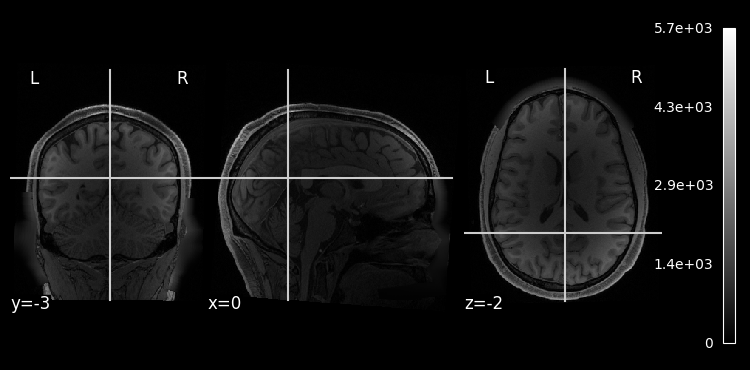

In [13]:
plot_anat(f"{sor_dir}/anat/{sub}_acq-MPR1_T1w.nii.gz")

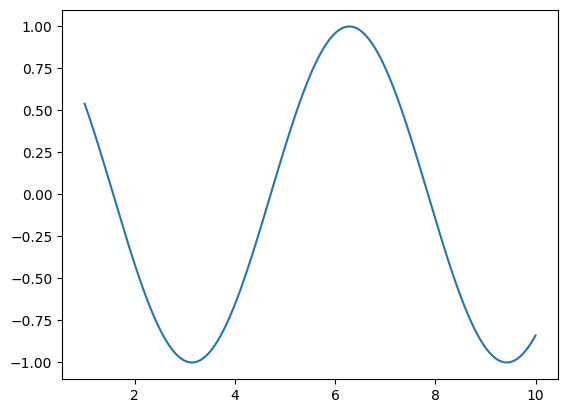

In [15]:
# import numpy: the module providing numerical arrays
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(1, 10, 2000)

plt.plot(t, np.cos(t))

plt.show()

In [18]:
import neuropythy as ny

sub = ny.freesurfer_subject(f"/users/kltoomer/datasets/hcp_retinotopy/derivatives/freesurfer/sub-01")
(lh_retino, rh_retino) = ny.vision.predict_retinotopy(sub)

/users/kltoomer/bric/.venv/lib64/python3.12/site-packages/neuropythy/datasets/benson_winawer_2018.py:188: RuntimeWarning: The default behavior of tarfile extraction has been changed to disallow common exploits (including CVE-2007-4559). By default, absolute/parent paths are disallowed and some mode bits are cleared. See https://access.redhat.com/articles/7004769 for more details.
  tar.extractall(path)


In [25]:
ny.save("lh_retino_b14", lh_retino, "nifti")
ny.save("rh_retino_b14", rh_retino, "nifti")

ValueError: could not convert string to float: np.str_('angle')

In [7]:
import neuropythy as ny

sub = ny.freesurfer_subject("/users/kltoomer/datasets/hcp_retinotopy/derivatives/freesurfer/sub-01/")

(lh_retino, rh_retino) = ny.vision.predict_retinotopy(sub)

/users/kltoomer/bric/.venv/lib64/python3.12/site-packages/neuropythy/datasets/benson_winawer_2018.py:188: RuntimeWarning: The default behavior of tarfile extraction has been changed to disallow common exploits (including CVE-2007-4559). By default, absolute/parent paths are disallowed and some mode bits are cleared. See https://access.redhat.com/articles/7004769 for more details.
  tar.extractall(path)


In [ ]:
# sorted(sub.images.keys())
(sub.lh, sub.rh)
(sub.lh.surface('white'), sub.lh.surface('pial'))

surf = sub.lh.surface('white')
surf.face_areas

array([0.37025836, 0.28666698, 0.35197296, ..., 0.16274774, 0.21499754,
       0.37056543], shape=(320084,))

In [16]:
sorted(sub.lh.properties.keys())


['BA1_label',
 'BA1_weight',
 'BA2_label',
 'BA2_weight',
 'BA3a_label',
 'BA3a_weight',
 'BA3b_label',
 'BA3b_weight',
 'BA44_label',
 'BA44_weight',
 'BA45_label',
 'BA45_weight',
 'BA4a_label',
 'BA4a_weight',
 'BA4p_label',
 'BA4p_weight',
 'BA6_label',
 'BA6_weight',
 'DKT40_parcellation',
 'Desikan06_parcellation',
 'Destrieux09_parcellation',
 'MT_label',
 'MT_weight',
 'V1_label',
 'V1_weight',
 'V2_label',
 'V2_weight',
 'atlas_curvature',
 'brodmann_area',
 'brodmann_area_wide',
 'convexity',
 'cortex_label',
 'curvature',
 'entorhinal_label',
 'entorhinal_weight',
 'index',
 'jacobian_norm',
 'label',
 'midgray_surface_area',
 'parcellation',
 'perirhinal_label',
 'perirhinal_weight',
 'pial_curvature',
 'pial_surface_area',
 'surface_area',
 'thickness',
 'white_curvature',
 'white_surface_area']